---
# Jupyter-Notebook-Tutorial:   

#    Anpassung von Modellen an Messdaten mit der Maximum-Likelihood-Methode

                                                    Günter Quast, Juni 2021
***
## Zusammenfassung

Dieses Tutorial führt in die Grundlage der Anwendung der Maximum-Likelihood-Methode
zur Anpassung an Messdaten ein. Für viele in der Praxis häufig auftretende Problemstellungen
ist die in zahlreichen Anwendungen und Programmpaketen implementierte Methode der "kleinsten
Fehlerquadrate" ("least squares", LSQ) nicht adäquat. Es sollte statt dessen die auf soliden
mathematischen Grundlagen beruhende Maximum-Likelihood-Methode ("Maximum Likelihood Estimation",
MSE) zur Schätzung der Modellparameter und ihrer Vertrauensbereiche angewandt werden. 

Dieses Tutorial in Form eines Jupyter-Notebooks bietet neben kurzen Erläuterungen der 
mathematischen Grundlagen insbesondere viele Code-Beispiele in der Sprache *Python*, 
die die Maximum-Likelihood-Methode an typischen Anwendungsbeispielen erläutern und zur 
Verwendung in eigenen Anpassungsproblemen modifiziert und erweitert werden können.

Der Beispielcode nutzt das *Python*-Paket [iminuit](https://iminuit.readthedocs.io/en/stable/)
zur numerischen Optimierung und Analyse der Unsicherheiten sowie die im wissenschaftlichen
Rechnen mit *Python* weit verbreiteten Bibliotheken *numpy*, *scipy* und *matplotlib*.
Als anwendungsorientierte Zwischenebene wird das Paket 
[PhyPraKit.phyFit](https://phyprakit.readthedocs.io/en/latest/) verwendet.



## Inhaltsübersicht:

1. Anpassung von Modellen an Messdaten

2. Mathematische Grundlagen der Parameterschätzung

   2.1 Parameterschätzung mit dem Maximum-Likelihood-Verfahren

   2.2 Beispiel 1: Anpassung einer Normalverteilung

   2.3 Bestimmung der Parameterunsicherheiten 

   2.4 Eigenschaften der Maximum-Likilihood-Schätzung
   
   2.5 Intervallschätzung

     - Bestimmung der Parameterunsicherheiten mit der  Profil-Likelihood

     - Konfidenzkonturen 

     - Beispiel 2: log-Likelihood Anpassung einer Exponentialfunktion

3. Anpassung von Verteilungsdichten an Histogramme

   3.1 Beispiel 
   
   3.2 Signifikanz eines Signals und Ausschlussgrenze 

4. Maximum-Likelihood und Methode der kleinsten Fehlerquadrate

   4.1 Konstruktion der Kovarianzmatrix

   4.2 Beispiel zur Anpassung an x/y-Daten mit komplexen Unsicherheiten  

5. Beurteilung der Qualität von Anpassungsverfahren

   5.1 Überprüfung mittels Monte-Carlo-Methode ("toy-MC")

---
## Grundsätzliches zu Jupyter Notebooks

Diese Datei vom Typ `.ipynb` enthält ein Tutorial als `Jupyter notebook`.
*Jupyter* bietet eine Browser-Schnittstelle mit einer (einfachen) Entwicklungsumgebung
für *Python*-Code und erklärende Texte im intuitiven *Markdown*-Format.
Die Eingabe von Formeln im *LaTeX*-Format wird ebenfalls unterstützt.

Eine Zusammenstellung der wichtigsten Befehle zur Verwendung von *Jupyter* als Arbeitsumgebung
findet sich im Notebook
[*JupyterCheatsheet.ipynb*](https://git.scc.kit.edu/yh5078/datenanalyse/-/blob/master/jupyter/JupyterCheatsheet.ipynb).
Grundlagen zur statistischen Datenauswertung finden sich in den Notebooks 
[*IntroStatistik.ipynb*](https://git.scc.kit.edu/yh5078/datenanalyse/-/blob/master/jupyter/IntroStatistik.ipynb)
und
[*Fehlerrechnung.ipynb*](https://git.scc.kit.edu/yh5078/datenanalyse/-/blob/master/jupyter/Fehlerrechnung.ipynb).

In *Jupyter* werden Code und Text in jeweils einzelne Zellen eingegeben. 
Aktive Zellen werden durch einen blauen Balken am Rand angezeigt.
Zellen können sich in zwei Zuständen befinden: im Edit-Mode ist das Eingabefeld weiß, 
im Command-Mode ist es ausgegraut.
Durch Klicken in den Randbereich wird der Command-Mode gewählt, ein Klick in das Textfeld einer
Code-Zelle schaltet in den Edit-Mode.
Die Taste `esc` kann ebenfalls verwendet werden, um den Edit-Mode zu verlassen.

Die Eingabe von `a` im Command-Mode erzeugt eine neue leere Zelle oberhalb der aktiven Zelle, 
`b` eine unterhalb. Eingabe von `dd` löscht die betreffende Zelle.

Zellen können entweder den Typ `Markdown` oder `Code` haben.
Die Eingabe von `m` im Command-Mode setzt den Typ Markdown, Eingabe von `y` wählt den Typ Code.

Prozessiert - also Text gesetzt oder Code ausgeführt - wird der Zelleninhalt durch Eingabe von
`shift+return`, oder auch `alt+return` wenn zusätzlich eine neue, leere Zelle erzeugt werden soll.

Die hier genannten Einstellungen sowie das Einfügen, Löschen oder Ausführen von Zellen sind
auch über das PullDown-Menü am oberen Rand verfügbar.

---

### Abhängigkeiten

Dieses Notebook nutzt Module aus dem Paket 
[PhyPraKit](https://github.com/GuenterQuast/PhyPraKit) vers. >=1.3.0, 
das von den Pakten *numpy*, *scipy*, *matplotlib* und *iminuit* abhängt.

---
---

## 1. Likelihood-Anpassung von Modellen an Messdaten
***
Die Physik als "Theorie-geleitete Erfahrungswissenschaft" lebt vom
Zusammenspiel theoretischer Hypothesenbildung und deren stringenter
Überprüfung im Experiment. Bei der Interpretation von Messdaten kommt
es daher zunächst darauf an, ob sie überhaupt einem erwarteten Modell 
entsprechen. Erst, wenn diese Frage mit "ja" beantwortet werden kann, 
ist die Extraktion vom Modellparametern sinnvoll.

Leider tragen die meisten der häufig verwendeten Werkzeuge in der 
Voreinstellung dieser Anforderung nicht Rechnung, sondern zielen 
auf eine möglichst genaue Parametrisierung der Daten ab. 
Bei Vorgabe von unpassenden Modellen werden dazu die Parameterfehler so 
weit vergrößert, dass die Parametrisierung trotzdem möglichst genau passt.

Um den besonderen Bedingungen der Datenauswertung in der Physik
gerecht zu werden, ist die Verwendung von eigenem Programmcode, 
idealerweise in der Programmiersprache *Python* in einem 
Jupyter-Notebook, häufig notwendig, da die meisten mittels einer
grafischen Oberfläche zu bedienenden Werkzeuge zur statistischen
Datenauswertung den Anforderungen nicht oder nur zum Teil genügen. 

Wichtige Anforderungen an eine Methode zur Modellanpassung sind:

- Alle Messunsicherheiten sollten direkt bei der Modellanpassung berücksichtigt
  und entsprechend modelliert werden, um sie vollständig und korrekt auf die
  Unsicherheiten der Parameter zu propagieren. Eine später von Hand
  durchgeführte Fehlerfortpflanzung ist aufwändig und funktioniert nur
  in einfachsten Fällen.   

- Häufig treten auch relative Unsicherheiten als Bruchteil des wahren 
  Messwerts auf, z.$\,$B. bei Kalibrationsunsicherheiten o.$\,$Ä..
  Solche relativen Unsicherheiten korrekt zu behandeln, gelingt mit der
  in vielen Anpassungsprogrammen implementierten Methode der kleinsten 
  Fehlerquadrate nur noch eingeschränkt. 
  Bessere Parameterschätzungen nutzen die Maximum-Likelihood-Methode 
  ("MLE", Maximum Likelihood Estimation) mit an das Problem angepassten
  Likelihood-Funktionen. 

- Sehr oft, insb. in der Quanten-, Kern- und Teilchenphysik, treten als 
  Messgrößen Zählraten in Abhängigkeit von Energie, Streuwinkel oder anderen
  Größen auf, die üblicherweise als Häufigkeitsverteilung (Histogramm)
  dargestellt werden. Die Einträge in einem Intervall eines Histogramms
  (einem sog. `Bin`) sind aber nicht Gauß-, sondern Poisson-verteilt. 
  Auch näherungsweise können Bins mit Null Einträgen mit einer - oft immer
  noch verwendeten - angepassten Methode der kleinsten Fehlerquadrate
  nicht berücksichtigt werden. Zur Anpassung von Modellen an Histogramme
  müssen also ebenfalls maximum-likelihood Methoden angewendet werden.
  
- Bei der Analyse von sehr kleinen Zählraten bei nur selten eintretenden
  Ereignissen kann schon die Notwendigkeit zur Aufteilung in Bins zur einem
  Informationsverlust und zu einer Verzerrung des Ergebnisses führen.
  In solchen Fällen sollte die Möglichkeit zur Durchführung eines ungebinnten
  Maximum-Likelihod-Fits zur Verfügung stehen.
  
- Bei der Anpassung an zweidimensionale Datenpunkte $(x_i, y_i)$ sollten 
  die verwendeten Werkzeuge Unsicherheiten in Abszissenrichtung (entlang
  der "x-Achse") zusätzlich zu denen in Ordinatenrichtung behandeln können. 
  Die Unterstützung von korrelierten Unsicherheiten ist ebenfalls notwendig, 
  um typische Charakteristika von Messgeräten, wie korrelierte 
  Kalibrationsunsicherheiten zusätzlich zu den unabhängigen 
  Digitalisierungsunsicherheiten und Rauschbeiträgen, darstellen zu können.

Leider gibt es kaum Anpassungswerkzeuge, die alle genannten Anforderungen
gleichzeitig erfüllen. Deshalb wurde am ETP in zahlreichen Bachelor-Arbeiten
ein quelloffenes Anpassungswerkzeug, [kafe2](https://github.com/dsavoiu/kafe2)
entwickelt, das die genannten Aspekte abdeckt. Allerdings ist der Programmcode
wegen der großen Zahl an Optionen und Methoden sehr komplex und für Einsteiger
unübersichtlich.

Zur Illustration der Vorgehensweise wird daher in diesem Tutorial ein
einziges, sehr flexibles Werkzeug zur numerischen Optimierung und 
Analyse der Parameterunsicherheiten verwendet, nämlich das am CERN 
entwickelte Paket `Minuit` bzw. dessen Python-Interface 
[iminuit](https://iminuit.readthedocs.io/en/stable/). 
Eine schlanke Implementierung von Anwendungsbeispielen bietet das Paket 
[PhyPraKit.phyFit](https://phyprakit.readthedocs.io/en/latest/), das 
hier verwendet wird, um die Grundlagen der Anpassung von Modellen an 
Messdaten mit der Maximum-Likelihood Methode darzustellen.  

***

## 2. Mathematische Grundlagen der Parameterschätzung
***

In diesem Tutorial werden ausgehend vom Maximum-Likelihood-Prinzip 
zunächst typische Anwendung zur Anpassung von Verteilungsdichten an
Messdaten diskutiert und dann die Verbindung zur altbekannten Methode
der kleinsten Quadrate zur Anpassung von parameterbehafteten 
Modellfunktionen $y_i = f(x_i; *par )$ an zweidimensionale Datenpunkte
$(x_i, y_i)$ dargestellt. 

Ausgangspunkt der Überlegungen ist der auf der Maximum-Likeliood Methode
basierende Formalismus zur Parameterschätzung von Verteilungsdichten, 
die den als statistische Stichprobe betrachteten Messergebnissen zu 
Grunde liegen. 
Manchmal sind die Parameter der Verteilungsdichte selbst interessant, 
z.$\,$B. bei der Lebensdauerverteilung von quantenmechanischen Zuständen 
oder von (Elementar-)Teilchen.
Häufig treten Parameter von Verteilungsdichten aber auch nur als 
"Störparameter" auf, die statistische Fluktuationen um einen angenommenen
wahren Wert beschreiben. Die Behandlung von Messunsicherheiten von 
Datenpunkten $(x_i, y_i)$ ist dafür ein Beispiel. 


## 2.1 Parameterschätzung mit dem Maximum-Likelihood Verfahren  

Beginnen wir an dieser Stelle mit der einfachsten Problemstellung, 
der Schätzung der Parameter der Verteilungsdichte einer Grundgesamtheit,
aus der eine endliche Stichprobe (="Daten") gezogen werden. 

Wir gehen von einer Verteilungsdichte ${\rm pdf}(x, \vec p)$ aus,
die von einer Anzahl von Parametern $p_j$ abhängt. Ein Datensatz
$\vec x$ besteht aus ${n_d}$ voneinander unabhängigen
Einzelmessungen $x_i$.

Nach dem Maximum Likelihood-Prinzip ist der beste Schätzwert der
Parameter ${\hat{ \vec {p}}}$ gegeben durch die Werte, die die
sog. `Likelihood`, das Produkt der Werte der $pdf$ für die
Einzelmessungen, ${\rm pdf}(x_i, \vec p)$, maximieren:

\begin{equation}\label{equ:Likelihood1}
  {\cal L}(\vec x, \vec p) =
  \displaystyle\prod_{i=1}^{n_d} \, {\rm pdf}(x_i, \vec p) \,.
\end{equation}  

Um unhandlich kleine Werte des Produkts zu vermeiden, aus Gründen
der numerischen Stabilität und auch aus mathematischen Gründen
(s. "Fisher-Information") verwendet man den negativen Logarithmus
von $\cal L$, die "negative log-Likelihood" $nl\cal L$, gegeben durch
\begin{equation}\label{equ:Likelihood2}
  {nl\cal L}(\vec x, \vec p) =
  -\displaystyle\sum_{i=1}^{n_d} \, \ln\left({\rm pdf}(x_i, \vec p)\right) \,.
\end{equation}  

Die negative log-Likelihood-Funktion wird als Funktion der Parameter
aufgefasst und bezüglich der Parameter minimiert. Üblicherweise verwendet
man sie als sogenannte "Kostenfunktion" in numerischen Optimierungsverfahren.

In der Physik ist es auch üblich, einen mit Zwei multiplizierten Wert zu 
verwenden, ${n2l\cal L}(\vec x; \vec p) = 2 \cdot {nl\cal L}(\vec x, \vec p)$.
Wie wir unten sehen werden, entspricht dies in Spezialfällen dem Wert der
Residuensumme, $S$, der nach dem von Gauß vorgeschlagenen Verfahren der 
kleinsten Fehlerquadrate häufig als Kostenfunktion verwendet wird. 

Es lässt sich zeigen, dass das log-Likelihood-Verfahren unter allen 
Verfahren zur Parameterschätzung optimal ist, also die kleinste Varianz 
der Parameterwerte liefert. Auch dies ist ein Grund, dem Likelihood-Verfahren
den Vorzug zu geben, wenn man maximalen Informationsgewinn aus bisweilen
extrem aufwändigen und damit teuren Experimenten ziehen möchte.


#### Likelihood und Wahrscheinlichkeitsdichte. 
Die Likelihoodfunktion ist im klassischen Sinn der frequentistischen Statistik 
keine Wahrscheinlichkeitsdichte  der Parameter $\vec p$, denn erstens ist
sie nicht normiert, und zweitens setzt sie sich aus Produkten von 
Wahrscheinlichkeiten zusammen, einen Wert $x_i$ zu beobachten wenn
die Parameterwerte vorgegeben sind.  
In der Interpretation der Bayes'schen Statistik
kann man aber unter Verwendung einer A-priori-Wahrscheinlichkeit, eines
sogenannten "Bayes-Priors" eine solche Wahrscheinlichkeitsdichte angeben.
Dazu wird das Bayes'sche Theorem verwendet:

$\displaystyle {\cal P}( p | \vec x) = \frac 
  { {\cal L}(\vec x | p) \, \cdot \, {\cal P}_p(p)} 
  {\cal P_x(\vec x)}  \, $.

In diesem Fall ist ${\cal P_x(\vec x)}$ eine Normierungskonstante, die dafür
sorgt, dass ${\cal P}( p | \vec x)$, die Wahrscheinlichkeit einen Parameterwert
$p$ zu beobachten, wenn die Daten festliegen. Wenn man z.B. annehmen kann, dass 
der Parameterbereich beschränkt ist und die Prior-Verteilung innerhalb dieses 
Bereichs flach ist, dann ist ${\cal P}_p(p)$ eine Gleichverteilung, also eine Konstante.
Es ist aber auch möglich und ein häufig genutztes Verfahren, Vorwissen über 
die Verteilung des Parameters $p$ aus anderen Untersuchungen als Verteilungsdichte
zu berücksichtigen. 


## 2.1 Beispiel 1: Anpassung einer Normalverteilung

Wir betrachten als erstes, einfache Beispiel Daten $(x_i)$, an die eine Gauß'sche 
Normalverteilung angepasst werden soll. 

Die Gaußverteilung mit Erwartungswert $\mu$ und Standardabweichung $\sigma$ ist  

${\cal N}(x; \mu, \sigma) \,=\, \frac{1}{\sqrt{2\pi} \, \sigma} \exp -{\frac{(x-\mu)^2}{2 \sigma^2}}\,$.

Das Zweifache des negativen natürlichen Logarithmus der Likelihood davon ist

$-2\, \ln({\cal N}(x; \mu, \sigma))\,=\, \left(\frac{x-\mu}{\sigma}\right)^2 + 2\ln(\sigma) + \ln (2\pi)\,$.

Den von allen Variablen unabhängigen Term $\ln(2\pi)$ kann man weglassen, 
weil er auf die Lage des Minimums keinen Einfluss hat. 

Die Kostenfunktion $n2l{\cal L}$ ist die Summe solcher Ausdrücke über alle $n_d$ Werte
einer Messreihe:

$n2l{\cal L} = 2 n_d \ln(\sigma) + 
                \displaystyle \sum_i^{n_d} \left(\frac{x_i-\mu}{\sigma}\right)^2\,$.

Durch partielles Differenzieren dieser Funktion nach den Parametern $\mu$ und $\sigma$
und Nullsetzen der Ableitungen kann man analytisch die optimalen Parameterwerte bestimmen.

Wir wollen zunächst den Schätzwert für den Parameter $\mu$ bestimmen und $\sigma$ als bekannt
und fest voraussetzen; $\sigma$ könnte z.B. die Auflösung einer Messapparatur sein, mit der
wir mehrfach Messungen der Größen $x_i$ durchführen. 
Man erhält nach kurzer Rechnung (die man in jedem Buch zur Statistik findet) für den
Maximum-Likelihood Schätzwert $\hat{\mu}$:

$\hat{\mu} = \displaystyle \frac{1}{n_d} \sum_i^{n_d} x_i \,$ .  
  
Das ist die erwartete Formel für den Mittelwert der Stichprobe, die also dem MLE-Schätzwert entspricht.

Wir fassen nun die Likelihood als Funktion von $\mu$ auf. Durch Einsetzen des Schätzwerts $\hat{\mu}$
und nach kurzer Umformung erhält man:

$\displaystyle n2l{\cal L}(\mu) = 
   2 n_d \ln(\sigma) + \frac{1}{n_d} \sum_i^{n_d} ({x_i}^2 - \hat{\mu}^2) + 
   \frac{n_d}{\sigma^2} (\mu -\hat{\mu})^2 \,=\, C \,+\, \frac{n_d}{\sigma^2} (\mu -\hat{\mu})^2\,, $
    
wobei mit $C$ alle Terme abgekürzt sind, die nicht vom Parameter $\mu$ abhängen.
Die erhaltene Darstellung ist eine Parabel mit Scheitelpunkt bei $\mu=\hat{\mu}$ und
Krümmung $\frac{2 n_d}{\sigma^2}$, deren Minimum den Wert $n2l{\cal L}(\hat{\mu}) = C$ hat.
Den Vorfaktor des quadratischen Terms identifizieren wir als das Inverse der Varianz des
Mittelwerts, $V_\hat{\mu} = {\sigma_\hat{\mu}}^2 = \sigma^2/n_d$. Damit kann man auch 
schreiben  
$\displaystyle 
n2l{\cal L}(\mu) =
C \,+\, \frac{1}{{\sigma_\hat{\mu}}^2} (\mu -\hat{\mu})^2$. 

Wenn man auch noch die Auflösung $\sigma$ als unbekannt annimmt und den Schätzwert aus den
Daten bestimmen möchte, so ist das Mimimum von $n2l{\cal L}(x_i; \mu, \sigma)$ durch Nullsetzen
beider partieller Ableitungen nach $\mu$ und $\sigma$ gegeben. Für den Schätzwert $\hat{\sigma}$ 
erhält man: 

$\hat{\sigma^2} = \displaystyle \frac{1}{n_d} \sum_i^{n_d} (x_i -\hat{\mu})^2 = \sum_i^{n_d} {x_i}^2 - {\hat{\mu}}^2 \,.$

### Numerisches Verfahren zur Bestimmung des Optimums

Weil es in diesem Tutorial um numerische Methoden zu Behandlung realistischer 
Problemstellungen gehen soll, die rein analytisch nicht mehr zugänglich sind, 
nutzen wir dieses bekannte und einfache Beispiel, um die numerische Herangehensweise 
zu illustrieren. Die dazu verwendeten Methoden können auch recht leicht auf 
allgemeinere und  komplexere Probleme mit komplizierteren Likelihood-Funktionen
angewandt werden. 

Mit Hilfe des folgen Codefragments werden zunächst (Pseudo-)Daten erzeugt:

In [1]:
import numpy as np

# generate Gaussian-distributed data

mu0 = 2.0
sig0 = 0.5
np.random.seed(314159)  # initialize random generator
data = mu0 + sig0 * np.random.randn(100)

Wie bei der Analyse von Daten aller Art üblich, sollte man sich zunächst einen Überblick
über die Daten verschaffen. Dazu gehören die Anzahl der Datenpunkte, Mittelwert, Median
und Standardabweichung.
Zur Visualisierung eignent sich die Darstellung als sog. "BoxPlot", der den Median, das
zentrale 50%-Quantil als Rechteck und den Bereich der Daten als  "Antennen" zeigt. 
Extremwerte, die weiter vom Rand des Rechtecks entfernt liegen als der Länge des Rechtecks 
entspricht, werden als als individuelle Datenpunkte ("Ausreißer") angezeigt.
Im Code-Beispiel unten werden zusätzlich die einzelnen Datenwerte als senkrechte Linien sowie 
Mittelwert und Standardabweichung als "Fehlerbalken" dargestellt. 


*==*  Data characteristics
  number of data points: 100
  minimum:             : 0.3326088712312858
  maximum:             : 3.1737215236386795
  mean of data         : 2.04
  median               : 2.09
  standard deviation   : 0.499

BoxPlot of data


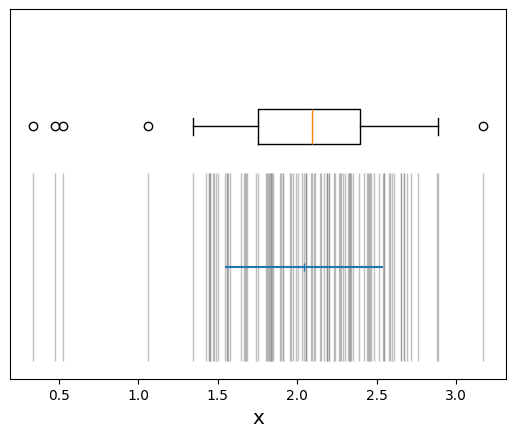

In [2]:
import matplotlib.pyplot as plt

# determine characteristics of the data
nd = len(data)
mn = min(data)
mx = max(data)
mean = data.mean()
med = np.median(data)
std = data.std()

print("\n*==*  Data characteristics")
print("  number of data points:", nd)
print("  minimum:             :", mn)
print("  maximum:             :", mx)
print("  mean of data         : {:.3g}".format(mean))
print("  median               : {:.3g}".format(med))
print("  standard deviation   : {:.3g}".format(std))

print("\nBoxPlot of data")

plt.boxplot(data, vert=False, whis=1.0)
plt.vlines(data, 0.0, 0.8, lw=1, color="grey", alpha=0.5, label="x")
plt.errorbar(mean, 0.4, marker="|", xerr=std)
tx = plt.xlabel("x", size="x-large")
plt.gca().yaxis.set_visible(False)

Wenn die Stichprobe groß genug ist, wie in unserem Fall, dann ist eine 
Häufigkeitsverteilung ebenfalls aussagekräftig, wie im folgenden Beispiel gezeigt. 


Histogram of data


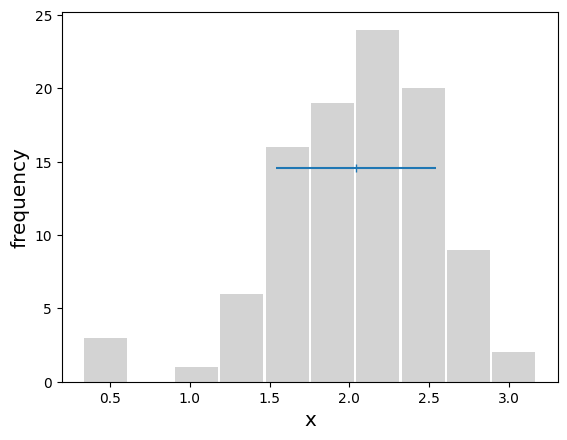

In [3]:
# plot histogram of the data
if nd < 30:
    print("\nHistogram of data not meaningful")
else:
    print("\nHistogram of data")
    nb = min(nd // 10, 50)
    bc, be, _ = plt.hist(data, nb, color="lightgrey", rwidth=0.95)
    plt.errorbar(mean, 0.6065 * max(bc), marker="|", xerr=std)
    tx = plt.xlabel("x", size="x-large")
    ty = plt.ylabel(
        "frequency",
        size="x-large",
    )

Zur Anpassung einer Normalverteilung an die Stichprobendaten verwenden wir 
nun ein numerisches Verfahren, das auf der Maximierung der Likelihood bzw.
Minimierung des negativen natürlichen Logarithmus der Likelihood beruht. 
In der numerischen Optimierung ist es üblich, eine solche zu optimierende
skalare Funktion als "Kostenfunktion" zu bezeichnen. 

Die Implementierung von $n2l{\cal L}$ als zu minimierende Kostenfunktion 
in *Python* ist einfach:

In [4]:
# define cost function: 2 * negative log likelihood of Gauß distribution
def myCost(mu=1.0, sigma=1.0):
    # simple -2*log-likelihood of a 1-d Gauss distribution
    r = (data - mu) / sigma
    return np.sum(r * r) + 2.0 * len(data) * np.log(sigma)

In der folgenden Codezelle wird das Paket MINUIT mit Hilfe des *Python*-basierten 
Interfaces *iminuit* zum Auffinden des Minimums der Kostenfunktion verwendet. 
Neben der Minimierung einer skalaren, von Parametern abhängigen Kostenfunktion 
bietet *iminuit* auch umfangreiche Methoden zur Steuerung der Anpassung und zur 
Analyse der Parameterunsicherheiten. 

Für unser einfaches Problem sieht der Code zur Verwendung von *iminuit* z.B. so aus:

In [5]:
# code for iminuit vers. >2.0
from iminuit import Minuit

# initialize Minuit object
m = Minuit(myCost, mu=1.0, sigma=1.0)
m.errordef = 1.0  # internal parameter, needed to control uncertainty analysis

# perform optimization
m.migrad()

# print results
print("parameter names: ", m.parameters)
print("best-fit values: ", tuple(m.values))

parameter names:  ('mu', 'sigma')
best-fit values:  (2.042703589998085, 0.49920606604299755)


Technisch einfacher wird die Anpassung mit Hilfe einer zusätzlichen Software-Ebene, 
die *Minuit* und das mächtige, aber damit auch notwendigerweise komplizierte Interface 
kapselt und so typische Anwendungsfälle vereinfacht, wie z.$\,$B. das 
Werkzeug [*kafe2*](https://github.com/dsavoiu/kafe2), 
oder das schlanke, im Paket *PhyPraKit* enthaltene Paket *phyFit*. 
Für Anpassungen mit *iminuit* bei vom Anwender vorgegebener Kostenfunktion ist die 
Interface-Funktion *mFit()* geeignet. Übergeben wird lediglich die Kostenfunktion; 
Rückgabewerte sind die aus den Keyword-Argumenten der Kostenfunktion bestimmten Namen 
und die Schätzwerte der Parameter. Zurückgegeben wird weiter eine Schätzung der 
Parameterunsicherheiten und eine Größe zur Einschätzung der Qualität der Anpassung. 
Über diese letztgenannten Größen wird weiter unten noch zu sprechen sein.  

Das Anpassungsbeispiel mit *mFit* benötigt klarerweise weniger eigenen Code
und sieht wie folgt aus: 

In [6]:
from PhyPraKit.phyFit import mFit

fit_results = mFit(myCost)

# Print results
print("\n*==* user-defined cost: Fit Result:")
print(" parameter names:       ", fit_results["parameter names"])
print(" parameter values:      ", fit_results["parameter values"])


*==* user-defined cost: Fit Result:
 parameter names:        ('mu', 'sigma')
 parameter values:       [2.04270359 0.49920607]


Die erhaltenen Werte sind identisch zu denen im Beispiel vorhin. 
Sie stimmen übrigens perfekt mit den erwarteten Ergebnissen aus den 
analytischen  Betrachtungen  von oben überein: 
$\mu$ ist ist der Erwartungswert und $\sigma$ ist die Standardabweichung
der Werte der Stichprobe. 

Die Parameterwerte sind allerdings nicht identisch zu denen, die für die Erzeugung
der Pseudo-Daten verwendet wurden. Die Abweichungen sind natürlich durch die endliche 
Größe der Stichprobe erklärbar.

Als letzen Schritt sollte man das erhaltene Ergebnis visuell überprüfen.
Dazu verwenden wir die Histogrammdarstellung und überlagern die angepasste
Funktion.


Histogram of data


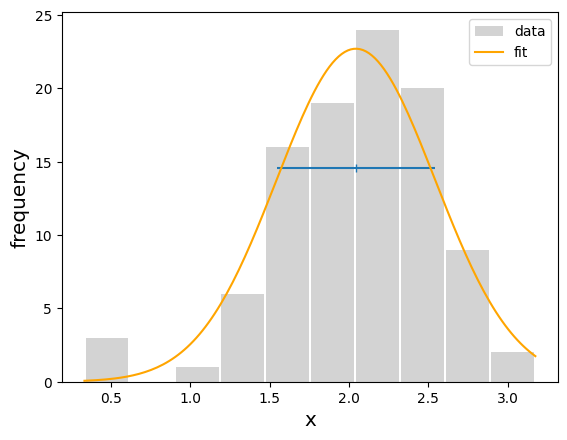

In [7]:
# plot histogram of the data and best-fit curve
from scipy.stats import norm

if nd < 30:
    print("\nHistogram of data not meaningful")
    bw = 1
else:
    print("\nHistogram of data")
    nb = min(nd // 10, 50)
    bc, be, _ = plt.hist(data, nb, color="lightgrey", rwidth=0.95, label="data")
    bw = be[1] - be[0]
    plt.errorbar(mean, 0.6065 * max(bc), marker="|", xerr=std)

# best-fit parameters
mu = fit_results["parameter values"][0]
sigma = fit_results["parameter values"][1]
# plot noraml distribution with these parameters
xp = np.linspace(mn, mx, 150)
plt.plot(xp, nd * bw * norm.pdf(xp, loc=mu, scale=sigma), color="orange", label="fit")
plt.legend(loc="best")
tx = plt.xlabel("x", size="x-large")
ty = plt.ylabel(
    "frequency",
    size="x-large",
)

## 2.3 Bestimmung der Parameterunsicherheiten

In diesem Abschnitt werden Methoden beschrieben und untersucht, mit 
deren Hilfe die statistischen Unsicherheiten der Schätzungen der
optimalen Parameterwerte untersucht werden können. Die Parameterschätzung
beruht ja auf einem Algorithmus, der als Eingabe Zufallsgrößen nutzt.
Daher sind die Ergebnisse der Schätzung selbst Zufallsgrößen, die eine 
nicht verschwindende Varianz haben. Das Ergebnis ist also erst vollständig
und als Ergebnis einer physikalischen Studie überhaupt erst vewendbar, wenn
auch die Unsicherheiten der Parameterwerte bekannt sind. 

Die Varianz der geschätzten Parameterwerte, oder besser die Kovarianzmatrix
der Unsicherheiten aller Parameter, lässt sich aus dem Verlauf der
log-Likelihood am Minimum bestimmen. Anschaulich ist ein Parameter
um so genauer bestimmt, je "schärfer" das Minimum ausgeprägt ist. 
Diesen Zusammenhang hatten wir oben bei der Darstellung der negativen
log-Likelihood Funktion für den Parameter $\mu$ einer Normalverteilung
schon vermutet. Einen mathematischen Beweis und eine allgemeingültige
Grenze für die Varianz haben unabhängig voneinander H. Cramér und C.R. Rao 
sowie später auch andere hergeleitet.
In der für uns passenden Form geschrieben, gilt für die Varianz einer
unverzerrten Schätzung $\hat{p}$ eines Parameters $p$:

${\rm Var}_{\hat p} = {\sigma_\hat{p}}^2 \ge 
\left[ { - \left.  \frac { {\partial}^2 \ln{\cal{L} }}
{{\partial p}^2 } \right|}_{\hat p}\right]^{-1}\,. $

Die kleinstmögliche Varianz eines Schätzwerts ist also durch das Inverse
der Krümmung der negativen log-Likelihood Funktion am Minimum gegeben.

Eine Modifikation ist notwendig, wenn es sich um eine verzerrte
Schätzung handelt, bei der eine Verzerrung (ein "Bias") 
$b := E[\hat{p}] - p_0$ auftritt, also eine Abweichung des Erwartungswerts 
des Schätzwerts vom wahren Wert $p_0$. 
Für Likelihood-Schätzungen geht die Verzerrung für große
Stichproben gegen Null. Ein Beispiel hatten wir schon oben bei
der Diskussion der Schätzung der Standardabweichung einer Normalverteilung
gesehen. Da man die Verzerrung im Allgemeinen nicht kennt und sie nur
für kleine Stichproben relevant ist, wird sie in der Praxis weggelassen
und in der  Cramér-Rao-Grenze für maximum-Likelihood-Schätzungen das 
Gleichheitszeichen angenommen, weil solche Schätzverfahren optimal
effizient sind.

Unter diesen Annahmen lässt sich das Verfahren zur Schätzung der 
Parameterunsicherheiten erweitern, um eine Schätzung der 
vollständigen Kovarianzmatrix aller Parameter zu erhalten:

\begin{equation}
\left( {\bf V}\right)_{ij} =
\left( { - \left. \frac {{\partial}^2 \ln{\cal{L}}}
{\partial p_i \, \partial p_j} 
\right|}_{\hat p_i \hat p_j}\right)^{-1}\,.
\end{equation}

Diese Methode zur Bestimmung der Parameterunsicherheiten wird in praktisch allen
Applikationen, Programmen und Bibliotheksfunktionen zur Parameteranpassung verwendet. 

Wenn die Zuverlässigkeit der so bestimmten Grenzen für die Parameterwerte
wichtig ist, sollten Ensembletests mit einer großen Anzahl an Pseudodatensätzen 
durchgeführt werden, wie sie weiter unten beschrieben werden. 

Die Bestimmung der vollständigen Kovarianzmatrix der Parameterunsicherheiten 
ist wichtig, weil Korrelationen zwischen den Parametern auch bei unkorrelierten 
Daten sehr häufig auftreten. Wenn die Korrelationen besonders groß sind, kann 
dies auch ein Hinweis auf eine ungeschickte Parametrisierung des Problems sein. 
Bei Korrelationen größer als 10% sollten sie als Teil des Ergebnisses unbedingt 
kommuniziert werden, weil die Form der innerhalb eines vorgegebenen 
Konfidenzniveaus noch zulässigen Parameterbereiche davon abhängt. 


#### Analyse der Parameterunsicherheiten in Beispiel 1

In unserem Beispiel mit *iminuit* von oben wurde die Analyse der Unsicherheiten
nach der beschriebenen Methode bereits durchgeführt, und wir können uns die 
Ergebnisse einfach ausgeben lassen. 
Das um entsprechenden Zeilen zur Ausgabe sehen so aus:

In [8]:
# print results of fit with iminuit
print("parameter names :", m.parameters)
print("best-fit values :", tuple(m.values))
print("uncertainties   :", tuple(m.errors))
print("covariace matrix:\n", np.asarray(m.covariance))

parameter names : ('mu', 'sigma')
best-fit values : (2.042703589998085, 0.49920606604299755)
uncertainties   : (0.04992060777524688, 0.035297968555754414)
covariace matrix:
 [[2.49206708e-03 3.81441624e-07]
 [3.81441624e-07 1.24594658e-03]]


Beim Aufruf der Funktion *mFit()* wurde (natürlich) auch gleich eine vollständige 
Analyse der Unsicherheiten durchgeführt.
Das um die Ausgabe von Unsicherheiten und Korrelationen ergänzte Beispiel 
sieht folgendermaßen aus:

In [9]:
# Print results
print("\n*==* user-defined cost: Fit Result:")
print(" parameter names:        ", fit_results["parameter names"])
print(" parameter values:       ", fit_results["parameter values"])
print(" parameter uncertainties:\n", fit_results["confidence intervals"])
print(" parameter correlations:\n", fit_results["correlation matrix"])


*==* user-defined cost: Fit Result:
 parameter names:         ('mu', 'sigma')
 parameter values:        [2.04270359 0.49920607]
 parameter uncertainties:
 [[-0.05004574  0.05004667]
 [-0.03330733  0.03750804]]
 parameter correlations:
 [[1.00000000e+00 2.16470393e-04]
 [2.16470393e-04 1.00000000e+00]]


Bitte beachten, dass die Analyse der Unsicherheiten in diesem Fall nach 
einem anderen Verfahren erfolgt ist, das unten beschrieben wird und das 
auch mit asymmetrischen Unsicherheiten umgehen kann, die relevant werden,
wenn die log-Likelihood am Minimum stark von einer Parabel abweicht. 

#### Grafische Analyse der negativen Log-Likelihood Funktion aus Beispiel 1

Für unser erstes Beispiel wollen wir zur Illustration den Verlauf von 
$n2l{\cal L}$ grafisch darstellen. In diesem einfachen Fall mit nur zwei
freien Parametern stellt dies bereits die Lösung des Minimierungsproblems dar. 

In der Codezelle unten ist dafür eine nützliche Hilfsfunktionen definiert.
Die Codierung der Kostenfunktion muss zu deren Verwendung noch angepasst 
werden, um eine optimale vektorbasierte Berechnung für Arrays von 
Eingabeparametern zu ermöglichen.
Für die Minimierung mit *iminuit* wurde die Kostenfunktion jeweils für
einzelnen Parameterwerte berechnet - zur grafischen Darstellung wollen wir
sie aber effizient in einem einzigen Aufruf auf einem zweidimensionalen 
Gitternetz auswerten. 

Die für diesen Fall angepasste Kodierung der Kostenfunktion ist ebenfalls 
in der Codezelle unten gezeigt.

In [10]:
from matplotlib import cm


def get_3Dfunction_data(
    xmin=1.0,
    xmax=1.0,
    ymin=-1.0,
    ymax=1.0,
    func=None,
    fkwargs={},
    delta_x=0.1,
    delta_y=0.1,
):
    """
    get function values on 2D-grid

    Args:
      float xmin: minimum x-range
      float xmax: maximum x-range
      float ymin: minimum y-range
      float ymys: maximum y-range
      funtion func: funtion f(x,y **kwargs)
      dict fkwargs: prameters to pass to function
      delta: resolution of grid

    Returns:
      tuple X, Y, Z
    """
    x = np.arange(xmin, xmax, delta_x)
    y = np.arange(ymin, ymax, delta_y)
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y, **fkwargs)
    return X, Y, Z


# define efficient version of cost function for arrays mu and sigma:
def plot_myCost(mu, sigma):
    # -2*log-likelihood of a 1-d Gauss distribution
    #  mu, sigma: numpy-arrays of parameter values
    n2lL = np.zeros_like(mu)
    for i in range(len(data)):
        n2lL += (data[i] - mu) * (data[i] - mu)
    n2lL /= sigma * sigma
    return n2lL + 2.0 * len(data) * np.log(sigma)

Einen recht guten quantitativen Überblick über eine skalare Funktion von zwei
Variablen erhält man, wenn eine Konturdarstellung, analog zu Höhenlinien
in der Geografie, gewählt wird. 
In dem für die Darstellung verwendeten Array kann man auch nach dem minimalen 
Wert und den zugehörigen Parameterwerten suchen und sie ausgeben.

Hier der Code dazu:

Minimum z = -38.941818495839556  at (x,y) =( 2.041599999999997 , 0.49983999999999884 )


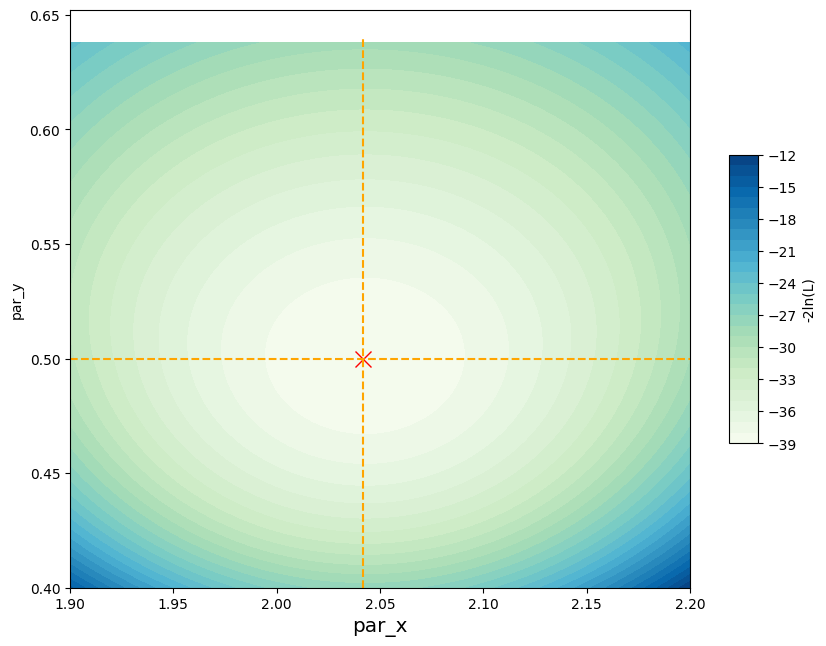

In [11]:
# plot cost function near minimum
# - ranges close to minimum
minx = 1.9
maxx = 2.2
miny = 0.4
maxy = 0.64
dx = (maxx - minx) / 125
dy = (maxy - miny) / 125
# get Z data for grid
X, Y, Z = get_3Dfunction_data(
    xmin=minx, xmax=maxx, ymin=miny, ymax=maxy, func=plot_myCost, delta_x=dx, delta_y=dy
)

# find and print x/y of minimum
minz = np.amin(Z)
i_xmn, i_ymn = np.unravel_index(np.argmin(Z), np.shape(Z))
x_opt = X[i_xmn, i_ymn]
y_opt = Y[i_xmn, i_ymn]
print("Minimum z =", minz, " at (x,y) =(", x_opt, ",", y_opt, ")")

# create figure ...
fig = plt.figure(figsize=(10.0, 7.5))
# ... plot (filled) contour lines ...
cont = plt.contourf(X, Y, Z, cmap="GnBu", levels=30)
# ... and plot (x,y) of minimum ...
plt.plot(x_opt, y_opt, marker="x", color="red", markersize=12)
plt.vlines(x_opt, miny, maxy, linestyles="dashed", color="orange")
plt.hlines(y_opt, minx, maxx, linestyles="dashed", color="orange")
# ... and add a legend
cbar = plt.colorbar(cont, shrink=0.5, aspect=10, label="-2ln(L)")
xl = plt.xlabel("par_x", size="x-large")
yl = plt.ylabel("par_y")

Einen guten Eindruck des Verhaltens am Minimum gewinnt man, wenn man den Verlauf der
Funktion am Minimum entlang der Achsenrichtungen darstellt, die in der Grafik oben als
orange, gestrichelte Linien eingezeichnet sind. Hier der Code für die x-Achse:

x-projection at minimum y


Text(0, 0.5, '-2ln(L)')

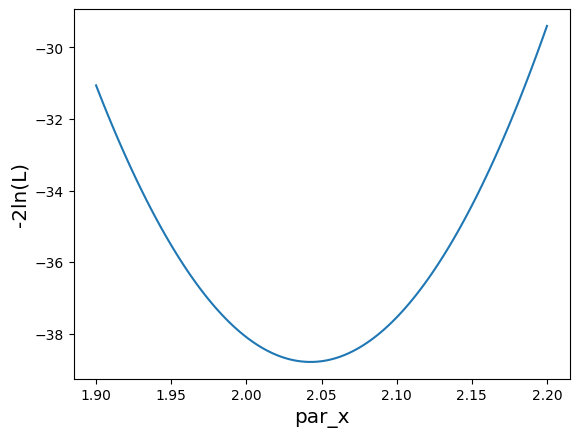

In [12]:
print("x-projection at minimum y")

# extract data for plot from X and Z arrays
pxvals = X[i_ymn, :]
proj_n2lLx = Z[i_ymn, :]

fig_x = plt.plot(pxvals, proj_n2lLx)
plt.xlabel("par_x", size="x-large")
plt.ylabel("-2ln(L)", size="x-large")

Und noch einmal fast das gleiche für die y-Achse:

y-projection at minimum x


Text(0, 0.5, '-2ln(L)')

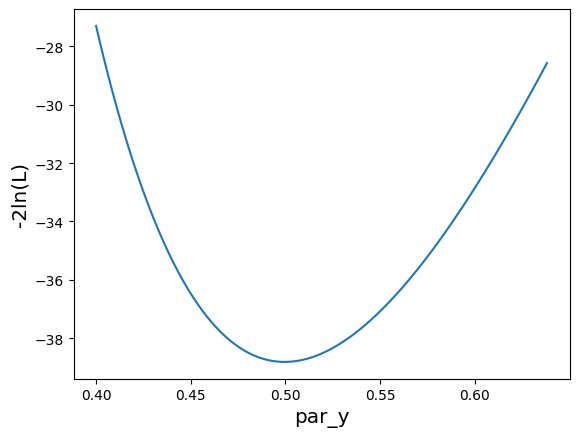

In [13]:
print("y-projection at minimum x")

# extract data for plot from Y and Z arrays
pyvals = Y[:, i_xmn]
proj_n2lLy = Z[:, i_xmn]

fig_y = plt.plot(pyvals, proj_n2lLy)
plt.xlabel("par_y", size="x-large")
plt.ylabel("-2ln(L)", size="x-large")

Man sieht, dass schon in diesem sehr einfachen Beispiel die negative log-Likelihood 
nicht für alle Parameter parabelfömig ist, sondern dass dies für den Parameter 
*mu=sigma* nur näherungsweise zutrifft. Wenn die Stichprobe vergrößert wird (bitte ausprobieren!),
stimmt die parabolische Näherung in der Nähe des Minimums immer besser, 
und das Minimum wird schärfer. Der nichtparabolische Verlauf ist der Grund dafür, 
dass die mit *mFit()* oben bestimmte Unsicherheit für diesen Parameter leicht asymmetrisch
war, nämlich $(-0.033, +0.038)$, während die symmetrischen Unsicherheiten als 
$\Delta\sigma=\pm 0.035$ ausgegeben wurden. 

Die mit dieser einfachen, auf der feingranularen grafischen Darstellung der 
negativen Log-Likelihood-Funktion basierende Methode erhaltenen Ergebnisse 
stimmen sehr gut mit den oben mit Hilfe der Fuktion *mFit()* und dem Paket 
*iminuit* erhaltenen Resultaten überein.


## 2.4 Eigenschaften der Maximum-Likilihood-Schätzung

Zur Charakterisierung von Verfahren zur Parameterschätzung werden einige grundlegende
Eigenschaften definiert. 

Da die Parameter $\hat{p}$ und ihre Unsicherheiten aus zufälligen Größen, 
den Daten, bestimmt werden, sind sie auch Zufallsgrößen mit Erwartungswerten 
$E[\hat{p}]$ und und Varianz $V[\hat{p}]$. 

Unabdingbar für ein brauchbares Verfahren ist die Forderung von **Konsistenz**,
d.h. dass mindestens im Grenzfall großer Stichproben für den Schätzwert $\hat{p}$ 
eines Parameters $p$ mit "wahrem Wert" $p_0$ gelten muss:

  - $\displaystyle \lim_{n \to \infty} \hat{p} = p_0$ .
  

Wünschenswert ist es, wenn für beliebige Stichprobengrößen gilt:
 
  - $E[\hat{p}] = p_0\, ;$
    diese Eigenchaft nennt man **Erwartungstreue**.
  

Als Maß für die Abweichung des Erwartungswerts einer Schätzung vom wahren Wert dient 
die **Verzerrung** (engl. "Bias"), 

  - $b = E[\hat{p}] - p_0 = 0\,; $   
    für große Stichproben muss wegen der geforderten Konsistenz gelten 
    $\displaystyle \lim_{n \to \infty} b = 0$.

Eine weitere wünschenswerte Eigenschaft ist die Forderung nach einer möglichst kleinen
Varianz der Schätzung $\hat{p}$:

  - $V[\hat{p}_i]$ minimal; Verfahren, die Cramér-Rao-Grenze erreichen nennt man
    **effizient** bzw. **optimal**.


Für viel Anwendungen, insbesondere bei der Verwendung von Schätzparametern in Hypothesentests,
ist die Angabe eines korrekten Konfidenzbereichs für den Parameter wichtiger
als die genaue Lage des Optimums, es geht in diesen Fällen also um die Schätzung eines
(Konfidenz-)Intervalls. Als Maß nutzt man die **Überdeckungswahrscheinlichkeit** 
(engl. "coverage"). Dies ist die Wahrscheinlichkeit, mit der das geschätzte 
$\pm 1 \sigma$-Intervall den wahren Parameterwert enthält:

  - $W(p_0\in [\hat{p} - \sigma_{\hat{p}}, \hat{p} +\sigma_{\hat{p}} ])\,$;
  für das $\pm 1 \sigma$-Intervall sollte dieser Wert nahe bei 0.683 liegen, 
  dem $\pm 1 \sigma$-Quantil der Gaußverteilung.

In der Praxis brauchbare Verfahren sollten auch möglichst unbeeinflusst von "Ausreißern" 
oder (leichten) Fehlmodellierungen der Daten sein. Diese Eigenschaft nennt man 
**Robustheit**. Sie ist allerdings quantitativ schwer zu fassen. 


**Beispiel: Schätzung der Parameter der Gaußverteilung**, $\hat{\mu}$ und $\hat{\sigma}$

Beispielhaft sollen diese Eigenschaften anhand des hier diskutierten Beispiels illustriert werden.

Die Schätzung des Erwartungswerts $\mu$ ist für beliebig kleine Stichproben 
erwartungstreu und effizient:

  - $b_\hat{\mu} = E\left[ \frac{1}{n_d} \sum_i^{n_d} x_i \right] - \mu =
     \frac{1}{n_d} \sum_i^{n_d}E[x_i]  - \mu = \frac{1}{n_d} \cdot n_d \mu - \mu = 0\,$,  
     d.h. $\hat{\mu}$ ist unverzerrt und damit erwartungstreu. 


  - $V_{\hat{\mu}} = V\left[\frac{1}{n_d} \sum_i^{n_d} x_i\right]= 
     \frac{1}{{n_d}^2} \sum_i^{n_d} V\left[ x_i \right]=
     \frac{1}{{n_d}^2} \sum_i^{n_d} \sigma^2 = \frac{\sigma^2}{n_d}\,$;  
    dieses Ergebnis ist identisch zum oben aus der Anwendung der Cramér-Rao-Grenze 
    bestimmten Wert, $\hat{\mu}$ ist also eine effiziente Schätzung. 

Etwas anders sieht es für die Schätzung der Varianz $v=\sigma^2$ aus. Aus der
grafischen Darstellung und auch aus der analytischen Form der Likelihoodfunktion 
ist ersichtlich, dass die negative log-Likelihood eine Asymmetrie um das Minimum
aufweist und von der Parabelform abweicht. 


  - $b_\hat{v} = E[\hat{v^2}] - \sigma^2 =
    E\left[ \frac{1}{n_d} \sum_i^{n_d} {x_i}^2 - {\hat{\mu}}^2 \right ] - \sigma^2 = 
    \frac{1}{n_d} \sum_i^{n_d} E[{x_i}^2] - {\hat{\mu}}^2 - \sigma^2 $.  
    Durch intelligentes Einsetzen einer Null,  $\mu^2 -  \mu^2$, erhält man  
    $b_{\hat{v^2}} = 
    \frac{1}{n_d} (\sum_i^{n_d} E[{x_i}^2] -\mu^2) - ({\hat{\mu}}^2  - \mu ^2) - \sigma^2 =
    \sigma^2 - {\sigma_{\hat{\mu}}}^2 - \sigma^2 = 
    {\sigma_{\hat{\mu}}}^2 = \frac{\sigma^2}{n_d} \ne 0  \,. $
    
    Diese Schätzung ist also verzerrt! Allerdings geht die Verzerrung für große Stichproben 
    $n_d \to \infty$  gegen Null, die Schätzung ist also "asymptotisch unverzerrt".   
    Oft ist die Verzerrung unerwünscht, und deshalb wendet man die sog. "Bessel-Korrektur" an, 
    um eine unverzerrte Schätzung der Varianz einer Stichprobe zu erhalten:
    ${\hat{\sigma}^*}^2 =  \displaystyle \frac{n_d}{n_d-1} \, {\hat{\sigma}}^2 = 
    \frac{1}{n_d-1} \sum_i^{n_d} {x_i}^2 -\hat{\mu}^2 \,$.
    
  - Als Cramér-Rao-Grenze für die Varianz von $v=\sigma^2$ erhält man unter Verwendung der
    oben angegebenen Formel, die die Verzerrung nicht berücksichtigt: 
    $V_{\hat{v}} \ge \frac{\sigma^4}{n_d/2}\,$.      
    Eine direkte Berechnung der Varianz aus der oben erhaltenen Formel für den
    Schätzwert von $\sigma^2$, $\hat{v}=\frac{1}{n_d} \sum_i^{n_d} {x_i}^2 - {\hat{\mu}}^2$ ergibt:
    
    $V_{\hat{v}} = \frac{n_d-1}{n_d}\frac{\sigma^4}{n_d/2}\,$;  
    dieser Wert ist sogar kleiner als der Grenzwert. Der Grund dafür ist die 
    unberücksichtigt gebliebene Verzerrung.
   
    Aus der **vollständigen Formel für die Cramér-Rao-Bedingung** unter Berücksichtigung der
    Verzerrung $b$,
    ${\rm Var}_{\hat p} = {\sigma_\hat{p}}^2 \ge 
    \left[ { - \left.  \frac { {\partial}^2 \ln{\cal{L} }} 
    {{\partial p}^2 } \right|}_{\hat p}\right]^{-1} \cdot
    \left[ 1 + \left. \frac{\partial b}{\partial p}\right|_\hat{p} \right]^2 $  
    ergibt sich allerdings 
    $V_{\hat{v}} \ge \left( \frac{n_d-1}{{n_d}}\right)^2 \frac{\sigma^4}{n_d/2}\,$;   
    d.h. die Varianz der Schätzung ist also tatsächlich größer als durch die (korrekt angewendete)
    Cramér-Rao-Grenze gegeben. Weil die Grenze erst für unendlich großer Stichproben erreicht
    wird, nennt man die Schätzung "asymptotisch effizient".

    !!! Übrigens: Programme zur Anpassung basieren ausnahmslos auf der einfachen Variante der 
    Cramér-Rao-Grenze und geben in diesem Fall also eine zu große Varianz aus!  
    
**Resumé:**
Die schon in diesem Beispiel sichtbaren Eigenschaften von Maximum-Likelihood-Schätzungen 
sind verallgemeinerbar. In einigen Fällen sind ML-Schätzungen effizient und unverzerrt, 
im Grenzfall großer Stichproben sind sie generell "asymptotisch effizient" und "asymptotisch
unverzerrt". Für Verteilungen aus der "Exponentialfamilie" werden diese Eigenschaften
schon unabhängig von der Stichprobengröße erreicht.   


## 2.5 Intervallschätzung

Wenn die negative log-Likelihood einen parabelförmigen Verlauf hat, ist es ausreichend,
nur die Schätzung des optimalen Werts eines Parameters $\hat{p}$ und seiner Varianz $V_p$
anzugeben. Dann wird als Konfidenzintervall für den Parameterwert ein symmetrischer Bereich
der Breite $2\cdot\sqrt{V_p}$ um den Schätzwert angenommen. 
ver
Bei kleinen Stichproben ist der Verlauf am Minimum aber häufig nicht mehr gut durch 
eine Parabel anzunähern, und die Angabe eines aus den zweiten Ableitungen am Punkt 
des Minimums berechneten symmetrischen Intervalls für die Unsicherheiten ist dann nicht
mehr ausreichend. In solchen Fällen verwendet man zur Abschätzung des Vertrauensintervalls
der Parameter die sogenannte **Profil-Likelihood** und leitet daraus ein Vertrauensintervall
mit vorgegebenem Konfidenzniveau ab - üblich ist es dabei, den $\pm 1 \sigma$-Bereich einer
Gaußverteilung zu Grunde zu legen, also ein Konfidenzniveau von 68.3%. Dies entspricht
der Wahrscheinlichkeit, einen Wert einer Gauß-verteilten Größe $x$ innerhalb des 
Intervalls $[\mu-\sigma, \mu+\sigma]$ zu finden. 

### Bestimmung der Parameterunsicherheiten mit der Profil-Likelihood

Zur Bestimmung der Profil-Likelihood wird für einen vorgegebenen Parameter $p_i$
eine Anzahl von dicht  in der Nähe des Minimums liegenden Punkten betrachtet und 
die negative log-Likelihood bezüglich aller übrigen Parameter $p_j, j\ne i$, minimiert. 
Auf diese Weise werden die Korrelationen von $p_i$ mit allen anderen Parametern $p_j$
berücksichtigt, und die Porfil-Likelihood ist eine Funktion nur eines einzigen Parameters,
${\cal L}_p(\vec x, p_i)$.

Das Vertrauensintervall, das dem Bereich plus/minus einer Standardabweichung einer
Gaußverteilung um den Parameterwert, also einem Konfidenzniveau von 68.3% entspricht, 
erhält man an den Stellen, an denen die negative log-Likelihood um den Wert
$\frac{1}{2}$ größer ist als am Minimum (bzw. um Eins größer, wenn 
man $-2\ln(\cal L)$ verwendet). 

Für parabolische Verläufe, wenn der negative Logarithmus der Profil-Likeliood
also die Form  $0.5\cdot ((p_i - \hat{p}_i)/\sigma_{p_i})^2$ hat, ist das 
Verfahren zur auf den zweiten Ableitungen basierenden Methode äquivalent. 
Ein Vorteil der Profil-Likelihood wird offensichtlich, wenn man Transformationen 
von Parametern betrachtet, also z.B. 
$nl{\cal L}(\vec{x};p) \to nl{\cal L}(\vec{x};\tilde{p})$ 
mit $\tilde{p} = \tilde{p}(p)$. 
Hat man für den Parameter $p$ einen Wert $p_{\Delta}$ bestimmt bei dem $nl{\cal L}$ 
um den Wert $\Delta$ ansteigt, so ergibt sich der Wert für $\tilde{p}$ durch 
einfaches Einsetzen: $\tilde{p}_{\Delta} = \tilde{p}(p_{\Delta})$. 
Da man durch eine geeignete Transformation $p \to {p_\cal N} = p_{\cal N}(p)$ 
beliebige Verteilungsdichten auf die Gaußform transformieren kann, 
lässt sich das mit der Methode bestimmte Konfidenzintervall als das 
äquivalente $\pm 1 \sigma$-Konfidenzintervall einer Gaußverteilung verstehen. 

Die durch die zweiten Ableitungen am Optimum festgelegte Varianz bzw. die 
Kovarianzmatrix der Parameter hat diese vorteilhafte Transformationseigenschaft
übrigens nicht, denn eine Parametertransformation führt zum Auftreten von Ableitungen
$\partial \tilde{p}/\partial p$; man bestimmt so also die Varianz der Parameter,
kennt aber die genaue Verteilungsdichte nicht! 
Der Scan der Profil-Likelihood liefert dagegen die Schätzung eines Konfidenzbereichs 
für die Parameterwerte - eine **Intervallschätzung**.

Durch Variation des Wertes von $\Delta$ lassen sich mit der gleichen Methode
auch andere Konfidenzintervalle bestimmen:  

|      |  ΔnlL  | Δn2lL |
| --:  |  :--:  | :--:  |
|  1σ  | 0.5    |   1   |
|  2σ  |  2     |   4   |
|  3σ  | 4.5    |   9   |
|  zσ  | z²/2   |   z²  |


Den Wert $z$ nennt man - in Anlehnung an den $p$-Wert eines Hypothesentests -
auch "$z$-Value". Er drückt ein Konfidenzintervall als Anzahl der äquivalenten
$\sigma$s einer Gaußverteilung aus. 

Bei nicht-parabolischen Verläufen ergibt sich aus der Analyse der Profil-Likelihood 
ein asymmetrisches Konfidenzintervall um den Parameterwert am Minimum, 
das in solchen Fällen an Stelle der aus den zweiten Ableitungen am Minimum bestimmen 
Schätzungen der Standardabweichungen der Parameter angegeben werden sollte.

Unter Verwendung des Bayes'schen Theorems und Vorgabe einer A-priori-Wahrscheinlichkeit 
${\cal P}(p_i)$ für den jeweils interessierenden Parameter $p_i$ kann aus der 
Profil-Likelihood eine Wahrscheinlichkeitsdichte abgeleitet werden:

$\displaystyle {\cal P}( p_i | \vec x) \propto  
  { {\cal L}_p(\vec x | p_i) \, \cdot \, {\cal P}_p(p_i)} \, $.


#### Grafische Darstellung der Profil-Likelihood zu Beispiel 1

Profil-Likelihoods lassen sich für unser Beispiel mit zwei Parametern direkt aus dem schon
für die grafische Darstellung genutzten Array erzeugen. Dazu muss der Code zur Darstellung
der Projektionen der negativen Log-Likelihood nur leicht ergänzt werden. Anstelle der Position
des globalen Minimums in $x$ bzw. $y$ wird nun das Minimum bzgl. $y$ bzw. $x$ für vorgegebene
Werte $x$ bzw. $y$ bestimmt. 

Zur Analyse der Profil-Likelihood ist es zweckmäßig, die an den Stützstellen der Arrays 
X und Y bestimmten Werte mit Hilfe von kubischen Splines (*scipy.interpolate.CubicSpline*) 
zu interpolieren, die zweimal stetig differenzierbar sind. 
Im Code unten ist dazu eine allgemein verwendbare Funktion *analyze_n2lLp()* definiert, 
die eine eindimensionale Profil-Likelihood auswertet und grafisch darstellt. 
Zunächst wird die dazu an den Stützstellen bestimme Profil-Likelihood durch einen kubischen 
Spline repräsentiert. Bestimmt werden daraus der optimale Parameterwert durch Nullsetzen 
der ersten Ableitung und die symmetrische Unsicherheit aus der zweiten Ableitung am
Optimalwert.
Zeichnet man die entsprechenden horizontale Linie bei $-\Delta 2\ln{\cal L}_{prof} = 1$ 
ein und projiziert die Schnittpunkte mit der Profil-Likelihood auf die $x$-Achse, erhält man 
das 68%-Konfidenzintervall für die Parameterunsicherheit. Die Schnittpunkte werden (natürlich) 
numerisch mit Hilfe des Newton-Verfahrens bestimmt. Üblicherweise zieht man bei der grafischen 
Darstellung den Minimalwert ab, weil nur die Änderung im Bezug auf das Minimum relevant ist. 

Hier der Code für den Logarithmus der Profil-Likelihood des in $x$-Richtung 
aufgetragenen Parameters, d.h. den Erwartungswert $\mu$ der Normalverteilung:


*==* Analysis of Profile Likelihood for parameter $\mu$
optimum: 2.043+/-0.05 [-0.05, +0.05]


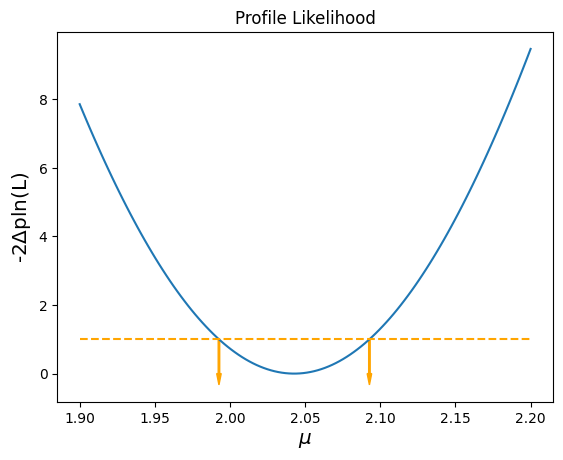

In [14]:
# extract data Z array
prof_n2lLx = np.zeros_like(pxvals)
for i, x in enumerate(pxvals):
    prof_n2lLx[i] = np.amin(Z[:, i])


def analyze_n2lLp(pvals, n2plL, name="p"):
    from scipy.interpolate import CubicSpline
    from scipy.optimize import newton

    """Analyze profile likelihood

  Input:
    - parameter values 
    - corresponding values of -2 *log(L_p) 
    - parameter name 
    
  Returns:
    - popt :  optimum (= min of profile likelihood) 
    - d_popt: uncertainty from 2nd derivative
    - d_pm:   negative uncertainty
    - d_pp:   positve uncertainty from profile likelihood scan
  """

    minp = min(pvals)
    maxp = max(pvals)
    # define interpolating cubic Spline
    n2plL = CubicSpline(pvals, n2plL)

    # calculate derivatives
    deriv = n2plL.derivative(nu=1)
    deriv2 = n2plL.derivative(nu=2)

    # find minimum using Newton method on 1st derivative
    popt = newton(deriv, x0=minp, x1=maxp)
    min_n2plL = n2plL(popt)
    # determin uncertainty from Cramer-Rao
    errdef = 1.0  # for 2negLogL, 0.5 else
    d_popt = np.sqrt(2.0 * errdef / deriv2(popt))

    # determine confidence interval of parameter from profile likelihood
    def f(x):
        return n2plL(x) - min_n2plL - errdef

    p_neg = newton(f, x0=minp, x1=popt)
    p_pos = newton(f, x0=popt, x1=maxp)
    d_pm = popt - p_neg
    d_pp = p_pos - popt

    # output
    print("*==* Analysis of Profile Likelihood for parameter", name)
    print(
        "optimum: {:.4g}+/-{:.2g} [-{:.2g}, +{:.2g}]".format(popt, d_popt, d_pm, d_pp)
    )

    # plot profile likelihood
    fig_p = plt.plot(pvals, n2plL(pvals) - min_n2plL)
    # plot lines for uncertainty analysis
    plt.hlines(1.0, minp, maxp, color="orange", linestyle="dashed")
    plt.arrow(p_neg, 1.0, 0.0, -1.0, head_length=0.33, color="orange")
    plt.arrow(p_pos, 1.0, 0.0, -1.0, head_length=0.33, color="orange")

    plt.title("Profile Likelihood")
    plt.xlabel(name, size="x-large")
    plt.ylabel("-2$\Delta$pln(L)", size="x-large")

    return popt, d_popt, d_pm, d_pp


val, dval, dm, dp = analyze_n2lLp(pxvals, prof_n2lLx, name=r"$\mu$")

Die Kurve sieht in diesem Fall fast genau so aus wie die einfache Projektion.
Das liegt daran, dass die Korrelation zwischen den Parametern klein ist und 
deshalb eine Änderung des $x$-Parameters kaum Einfluss auf den $y$-Parameter hat.

Hier noch der Code für die Standardabweichung $\sigma$ der Normalverteilung, die
wir in der grafischen Darstellung in  $y$-Richtung aufgetragen hatten. 
Zur Analyse und grafischen Darstellung der Profil-Likelihood verwenden wir wieder 
die eben schon definierte Funktion *analyze_n2lLp()*:

*==* Analysis of Profile Likelihood for parameter $\sigma$
optimum: 0.4992+/-0.035 [-0.033, +0.037]


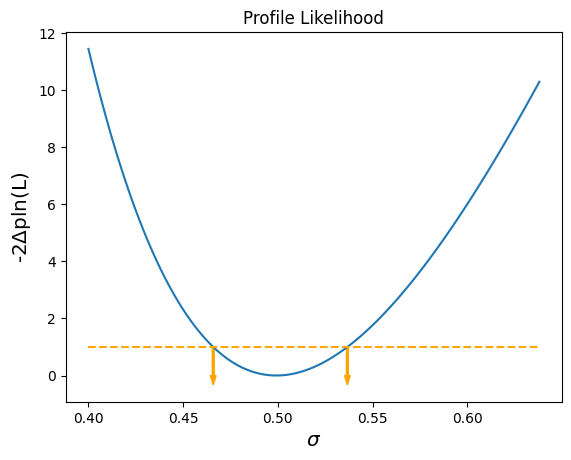

In [15]:
# extract nlL values from Z array
prof_n2lLy = np.zeros_like(pyvals)
for i, y in enumerate(pyvals):
    prof_n2lLy[i] = np.amin(Z[i, :])

val, dval, dm, dp = analyze_n2lLp(pyvals, prof_n2lLy, name=r"$\sigma$")

Diese der Illustration des Verfahrens dienende Vorhehensweise funktioniert
nur für einfache Problemstellungen mit maximal zwei Parametern und ist numerisch
nicht effizient, wenn gar keine grafische Darstellung benötigt wird.

Wenn mehr Parameter im Spiel sind oder die Effizienz der Berechnungen von Bedeutung
ist, sollten *iminuit* oder, komfortabler, die Interface-Funktionen aus den Paketen 
*phyFit* oder *kafe2* verwendet werden.


### Profil-Likelihood in zwei Dimensionen: Konfidenzkonturen

Das Prinzip der Profil-Likelihood lässt sich auch in zwei Dimensionen,
also für Paare von Parametern, anwenden. Man erhält dann Konturlinien,
die Konfidenzbereichen analog zu ein- oder auch zwei-$\sigma$-Konturen von 
Gauß-förmigen Verteilungen entsprechen. Bei starker Abweichung der Konturen 
von der Ellipsenform sollten sie zusammen mit dem Ergebnis berichtet werden.

Da das numerische Verfahren aufwändig ist, sollten zur Darstellung von 
Konfidenzkonturen die Implementierungen in den Paketen *iminiut* oder
*kafe2*  verwendet werden. 

#### Profil-Likelihood und Konfidenzkonturen mit Hilfe der Funktion *phyFit.mFit()*

Profile-Likelihood-Kurven und Konfidenzkonturen können leicht auch mit der 
Funktion *mFit()* erzeugt werden, wenn die zusätzliche Option `plot_cor=True` 
angegeben wird. Ansonsten ist der Code identisch zum bereits oben besprochenen
ersten Beispiel mit *mFit()*:

<Figure size 640x480 with 0 Axes>

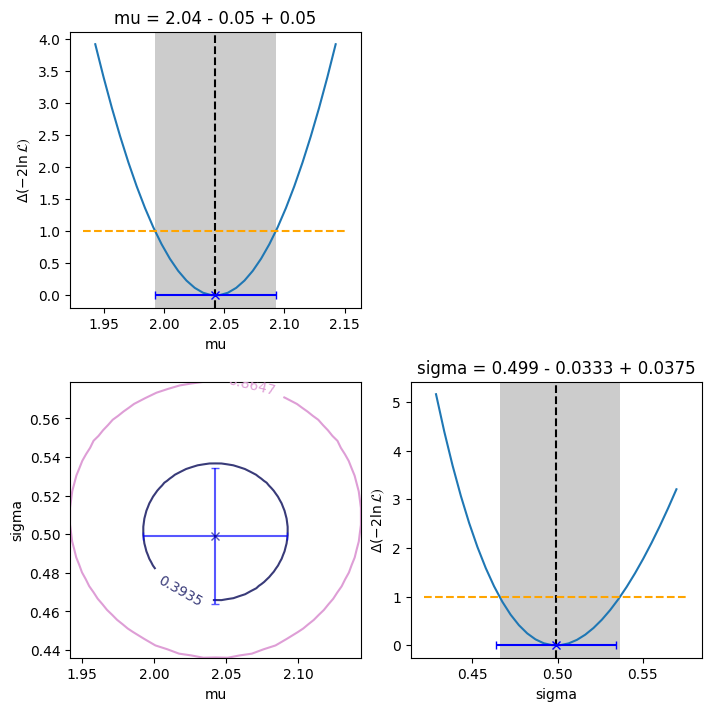


*==* user-defined cost: Fit Result:
 parameter names:        ('mu', 'sigma')
 parameter values:       [2.04270359 0.49920607]
 neg. parameter errors:  [-0.05004574 -0.03330733]
 pos. parameter errors:  [0.05004667 0.03750804]
 correlations : 
 [[1.00000000e+00 2.16470393e-04]
 [2.16470393e-04 1.00000000e+00]]


In [16]:
fit_results = mFit(myCost, plot_cor=True)

# Print results
pvals, perrs, cor, gof, pnams = fit_results.values()
print("\n*==* user-defined cost: Fit Result:")
print(" parameter names:       ", pnams)
print(" parameter values:      ", pvals)
print(" neg. parameter errors: ", perrs[:, 0])
print(" pos. parameter errors: ", perrs[:, 1])
print(" correlations : \n", cor)

In der mit dem Code oben erzeugten Matrix aus Grafiken werden auf der Diagonalen die
Verläufe der Profil-Likelihood angezeigt; in den unteren Nebendiagonalelementen sind
die ein- und zwei-$\sigma$ Konturen dargestellt. Die Fehlerbalken sind die aus der Analyse
der zweiten Ableitungen gewonnenen Unsicherheiten, die für $\Delta\mu$ perfekt und 
für $\Delta\sigma$ noch recht gut mit den mit Hilfe der Profil-Likelihood bestimmten Konfidenzintervallen übereinstimmen. 

#### Direkte Anpassung einer Verteilungsdichte an Daten mit der Funktion *phyFit.mFit()*

Die Funktion *mFit()* bietet ein weiters Interface zur Durchführung von Anpassungen mit der ML-Methode an, bei denen als Eingaben die Daten die Verteilungsdichte angegeben werden. Damit kann *mFit()* auch die Darstellung der Daten und der angepassten Verteilungsdichte inklusive eines Konfidenzbands um die Modellfunktion übernehmen (Option `plot=True`).
Die zusätzliche Option `plot_cor=True` ist ebenfalls verfügbar und erzeugt die gleiche
Ausgabe wie im  vorigen Beispiel. Zusätzlich sind im Beispiel in der Codezelle unten noch einige weitere Optionen zur Beschriftung der Achsen und der Legende angegeben. 

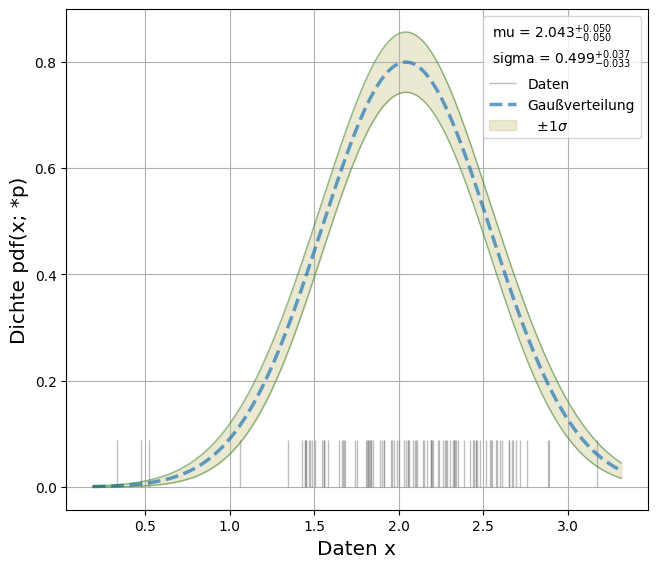

In [17]:
# Definition der Gaußvereteilung
def fGauss(x, mu=10.0, sigma=0.5):
    return np.exp(-((x - mu) ** 2) / 2.0 / sigma**2) / np.sqrt(2.0 * np.pi) / sigma


# Anpassung Verteilungsdichte an Daten
rdict = mFit(
    fGauss,
    data=data,  # data - if not None, normalised PDF is assumed as model
    plot=True,  # plot data and model
    #          plot_cor=True,          # plot profiles likelihood and contours
    axis_labels=["Daten x", "Dichte pdf(x; *p)"],
    data_legend="Daten",
    model_legend="Gaußverteilung",
)

### Beispiel 2: log-Likelihood Anpassung einer Exponentialfunktion

Wir wollen nun ein etwas komplexeres, realistisches Beispiel zur Anpassung von
Parametern an Daten mit Hilfe des Maximum-Likelihood Verfahrens anschauen. 

Dazu verwenden wir echte Messungen der Lebensdauern von gestoppten 
kosmischen Myonen, die in einem Wasser-Cherenkov-Detektor (in diesem Fall 
einer Kaffeekanne mit Photomultiplier) nachgewiesen wurden. Beim Durchgang 
durch das Wasser erzeugen die Myonen ein Lichtsignal; wenn sie im Wasser
oder im Boden darunter gestoppt werden, können Elektronen aus den zerfallenden
Myonen wieder in den Detektor gelangen und ebenfalls nachgewiesen werden. 
Die Daten entsprechen den Zeitdifferenzen (in µs) solcher Doppelpulse. Zufällig
eintreffende Myonen, Umgebungsstrahlung und evtl. Detektorrauschen erzeugen 
ebenfalls Doppelpulse, die im Gegensatz zu den Lebensdauern aber flach verteilt
sind und einen Untergrund bei der Lebensdauermessung darstellen.

Die relevante, auf Eins normierte Verteilungsdichte und die Daten finden 
sich in der folgenden Code-Zelle:

In [18]:
def exponentialDecayPDF(t, tau=2.0, fbg=0.2, a=1.0, b=11.5):
    """Probability density function

    for an exponential decay with flat background. The pdf is normed for the interval
    [a=1µs,  b=11.5µs); these parameters a and b must be fixed in the fit!
    """

    # 1.) Exponential distribution of life time measuremtens in the intervall [a, b]
    pdf1 = np.exp(-t / tau) / tau / (np.exp(-a / tau) - np.exp(-b / tau))

    # 2. flat distribution in the interval [a, b]
    pdf2 = 1.0 / (b - a)

    # the full distribution is a combination of both, with a background fraction fbg
    return (1 - fbg) * pdf1 + fbg * pdf2


# real data from measurement with a Water Cherenkov detector ("Kamiokanne")
dT = [7.42, 3.773, 5.968, 4.924, 1.468, 4.664, 1.745, 2.144, 3.836, 3.132, 1.568, 2.352,
      2.132, 9.381, 1.484, 1.181, 5.004, 3.06, 4.582, 2.076, 1.88, 1.337, 3.092, 2.265,
      1.208, 2.753, 4.457, 3.499, 8.192, 5.101, 1.572, 5.152, 4.181, 3.52, 1.344, 10.29,
      1.152, 2.348, 2.228, 2.172, 7.448, 1.108, 4.344, 2.042, 5.088, 1.02, 1.051, 1.987,
      1.935, 3.773, 4.092, 1.628, 1.688, 4.502, 4.687, 6.755, 2.56, 1.208, 2.649, 1.012,
      1.73, 2.164, 1.728, 4.646, 2.916, 1.101, 2.54, 1.02, 1.176, 4.716, 9.671, 1.692,
      9.292, 10.72, 2.164, 2.084, 2.616, 1.584, 5.236, 3.663, 3.624, 1.051, 1.544, 1.496,
      1.883, 1.92, 5.968, 5.89, 2.896, 2.76, 1.475, 2.644, 3.6, 5.324, 8.361, 3.052,
      7.703, 3.83, 1.444, 1.343, 4.736, 8.7, 6.192, 5.796, 1.4, 3.392, 7.808, 6.344,
      1.884, 2.332, 1.76, 4.344, 2.988, 7.44, 5.804, 9.5, 9.904, 3.196, 3.012, 6.056,
      6.328, 9.064, 3.068, 9.352, 1.936, 1.08, 1.984, 1.792, 9.384, 10.15, 4.756, 1.52,
      3.912, 1.712, 10.57, 5.304, 2.968, 9.632, 7.116, 1.212, 8.532, 3.000, 4.792, 2.512,
      1.352, 2.168, 4.344, 1.316, 1.468, 1.152, 6.024, 3.272, 4.96, 10.16, 2.14, 2.856,
      10.01, 1.232, 2.668, 9.176]


Die Anpassung mit Hilfe des log-Likelihood-Verfahrens funktioniert genau so 
wie oben. Dieses Mal werden allerdings an Stelle der Kostenfunktion die Daten
und die Verteilungsdichte sowie weitere Optionen zur grafischen Darstellung 
als Parameter angegeben. Damit die Anpassung funktioniert, muss das
Anpassungswerkzeug einige besondere Optionen unterstützen: 
- die Begrenzung von Parametern auf einen sinnvollen Bereich   
  (Option `limits=('fbg', 0., 1.)`) und 
- die Fixierung von Parametern, die in der Anpassung nicht variiert werden. 
  In diesem Fall ist dies das Intervall, in dem die Messungen verlässlich sind
  und auf das die Verteilungsdichte normiert ist      
  (Option `fixPars = ['a', 'b']`).
  
Hier nun der vollständige Programmcode zur Anpassung einer Verteilungsdichte
an (ungebinnte) Daten:

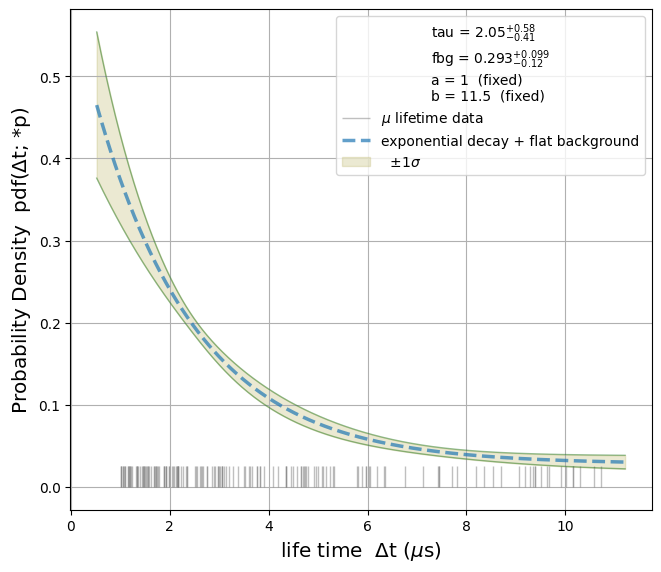

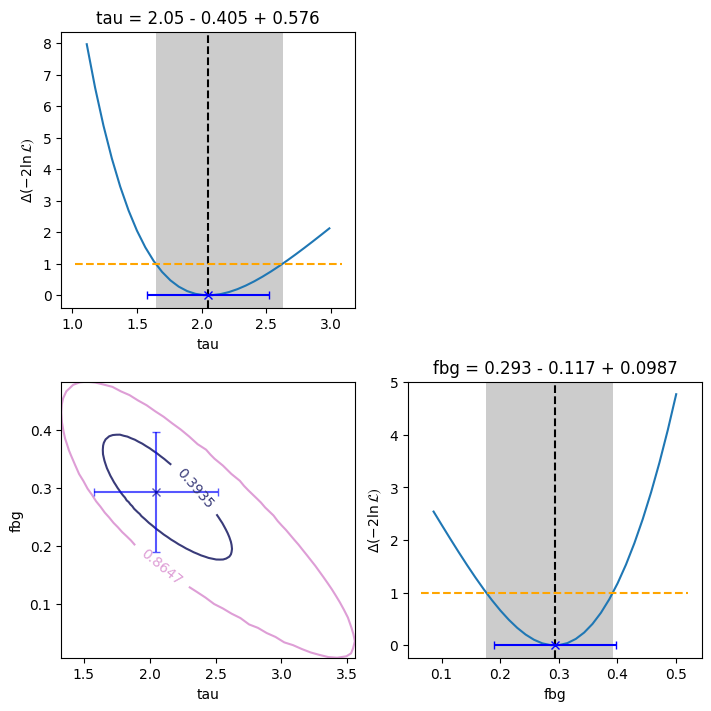


*==* unbinned ML Fit Result:
 parameter names:        ['tau' 'fbg' 'a' 'b']
 parameter values:       [ 2.04952279  0.29330093  1.         11.5       ]
 neg. parameter errors:  [-0.40510342 -0.1168369 ]
 pos. parameter errors:  [0.57553675 0.09874637]
 correlations : 
 [[ 1.         -0.77785875]
 [-0.77785875  1.        ]]


In [19]:
results = mFit(
    exponentialDecayPDF,
    data=dT,  # data - if not None, a normalised PDF is assumed as model
    limits=("fbg", 0.0, 1.0),  # parameter limits
    fixPars=["a", "b"],  # fix parameter(s)
    neg2logL=True,  # use  -2 * ln(L)
    plot=True,  # plot data and model
    plot_band=True,  # plot model confidence-band
    plot_cor=True,  # plot profiles likelihood and contours
    axis_labels=[
        "life time  " + "$\Delta$t ($\mu$s)",
        "Probability Density  pdf($\Delta$t; *p)",
    ],
    data_legend="$\mu$ lifetime data",
    model_legend="exponential decay + flat background",
)

# Print results
pvals, perrs, cor, gof, pnams = results.values()
print("\n*==* unbinned ML Fit Result:")
print(" parameter names:       ", pnams)
print(" parameter values:      ", pvals)
print(" neg. parameter errors: ", perrs[:, 0])
print(" pos. parameter errors: ", perrs[:, 1])
print(" correlations : \n", cor)

Anders als bei der Anpassung der Normalverteilung an Gauß-verteilte Daten zeigen die
Profil-Likelihoods starke Abweichungen von der Parabelform, und die Kontur weicht stark
von der Form einer Ellipse ab. 
In einem solchen Fall ist die Bereitstellung der Grafiken zusätzlich zur Angabe der numerischen Ergebnisse notwendig. Auch die stark asymmetrischen Unsicherheiten müssen angegeben werden.  

---

## 3. Anpassung von Verteilungsdichten an Histogramme
***

Ein weiteres typisches Beispiel für die Anwendung der log-Likelihood-Methode
ist die Behandlung von Problemen, bei denen Poisson-verteilte Größen
auftreten. Dies sind z.$\,$B. die Anzahlen von Einträgen in einzelnen
Intervallen von Häufigkeitsverteilungen (Histogramme).

Die Poissonverteilung von Anzahlen $n_i$ mit Erwartungswerten $\mu_i$
ist gegeben durch

\begin{equation}\label{equ-Poisson}
  P(n_i;\mu_i)=\frac{{\mu_i}^{n_i}} {n_i\,!} \, {\rm e}^{-\mu_i} \,.
\end{equation}

Durch Bilden des Produkts über alle (als statistisch unabhängig
angenommenen) $n_b$ Bins eines Histogramms erhält man die Likelihood 

\begin{equation}\label{equ-LPoisson}
  {\cal{L}}_{Poisson}=\displaystyle\prod_{i=1}^{n_b}
  {\rm P}\left(n_i;\mu_i(\vec p)\right)\, ,
\end{equation}

und schließlich durch Logarithmieren und Weglassen des nicht von den 
Parametern abhängigen Terms $\ln(n!)$ die negative log-Likelihood der
Poisson-verteilten Anzahlen der Einträge in den Bins eines Histogramms
\begin{equation}\label{equ-nlLPoisson}
nl{\cal{L}}_{Poisson}= -\ln {\cal{L}}_{Poisson} =
\displaystyle\sum_{i=1}^{n_b} - n_i \cdot \ln(\mu_i(\vec p))\,+\,\mu_i(\vec p) \,.
\end{equation}

Bei Verwendung dieser Kostenfunktion im Minimierungsprozess können
Anpassungen von Verteilungsdichten an Histogramme ganz analog wie bei
der Verwendung der oben bereits diskutierten Likelihood zur Anpassung
von Verteilungsdichten an Messdaten durchgeführt werden, die in diesem
Fall aber als Histogramm vorliegen. 
Der Rechenaufwand hängt von der Zahl der Bins und nicht - wie im ersten Beispiel - 
von der Größe des Datensatzes ab. 

Die Anzahl der auf Grund der Verteilungsdichte erwarteten Einträge $n_i$ 
bestimmt man sinnvollerweise durch Bildung des Integrals der Verteilung
über die Binbreite - eine numerische Näherung (z.B. Simpson 2. Ordnung)
ist meist ausreichend. 

In manchen Fällen wird auch eine Gauß-Näherung der Poisson-Verteilung
verwendet,  $P(n_i;\mu_i) = {\cal N}(n_i; \mu_i, \sigma=\sqrt{\mu_i})$.
Bei großen Anzahlen an Bin-Einträgen ist diese Näherung akzeptabel und
erlaubt häufig die Anwendung von Programmen zur Anpassung, die auf
der Methode der kleinsten Fehlerquadrate beruhen und daher nur eine
auf der Gaußverteilung beruhende Kostenfunktion erlauben. 

Wichtig ist es, die Schätzung der Unsicherheiten $\sigma_i = \sqrt{\mu_i}$
aus der Modellerwartung und nicht aus den beobachteten Werten in den
Daten zu bestimmen, da letzteres zu einer verzerrten Parameterschätzung
führen würde und Bins mit Null Einträgen sogar weggelassen werden müssten. 
Im Notfall kann man sich behelfen, indem zunächst eine Anpassung mit den aus
der Beobachtung gewonnenen Unsicherheiten durchgeführt wird, die in 
einer wiederholten Anpassung durch die aus der dann näherungsweise bekannten 
Modellerwartung gewonnenen Werte ersetzt werden.
Bei den empfohlenen Werkzeugen *kafe2* und *phyFit* sind solche Umstände
allerdings nicht notwendig, da sie als Voreinstellung das korrekte, oben 
skizzierte Likelihood-Verfahren für die Anpassung an Histogrammdaten nutzen. 


### 3.1 Beispiel: Anpassung an Histogramm-Daten

Die Anpassung eines Modells an histogrammierte Daten wird durch die Funktion
*hFit()* aus dem Paket *PhyPraKit.phyFit* unterstützt. Die Vorgehensweise ist ganz
analog zur Anpassung von ungebinnten Daten. Von Anwenderseite müssen lediglich
die Daten und die Verteilungsdichte bereit gestellt sowie Angaben zu den 
Ausgabeoptionen gemacht werden. Die passenden Kostenfunktionen, also das zweifache
des negativen natürlichen Logarithmus der Poissonverteilung - oder, oft in 
ausreichender Näherung der Gaußverteilung - sind in *hFit()* implementiert. 

Hier das vollständige Programmbeispiel:

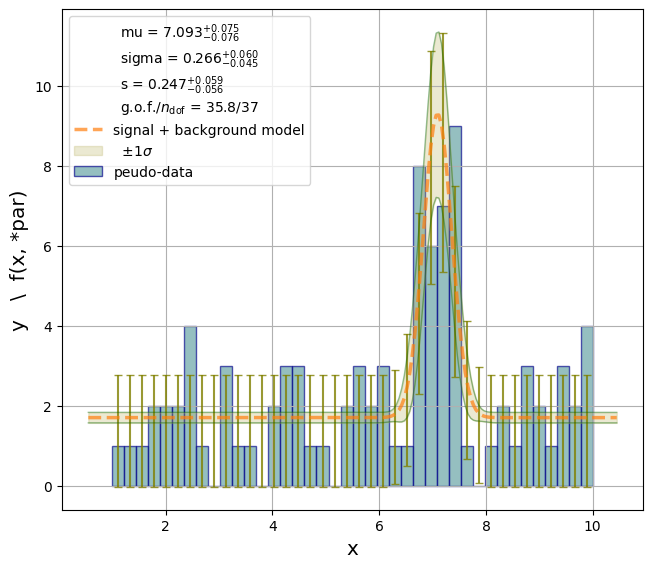

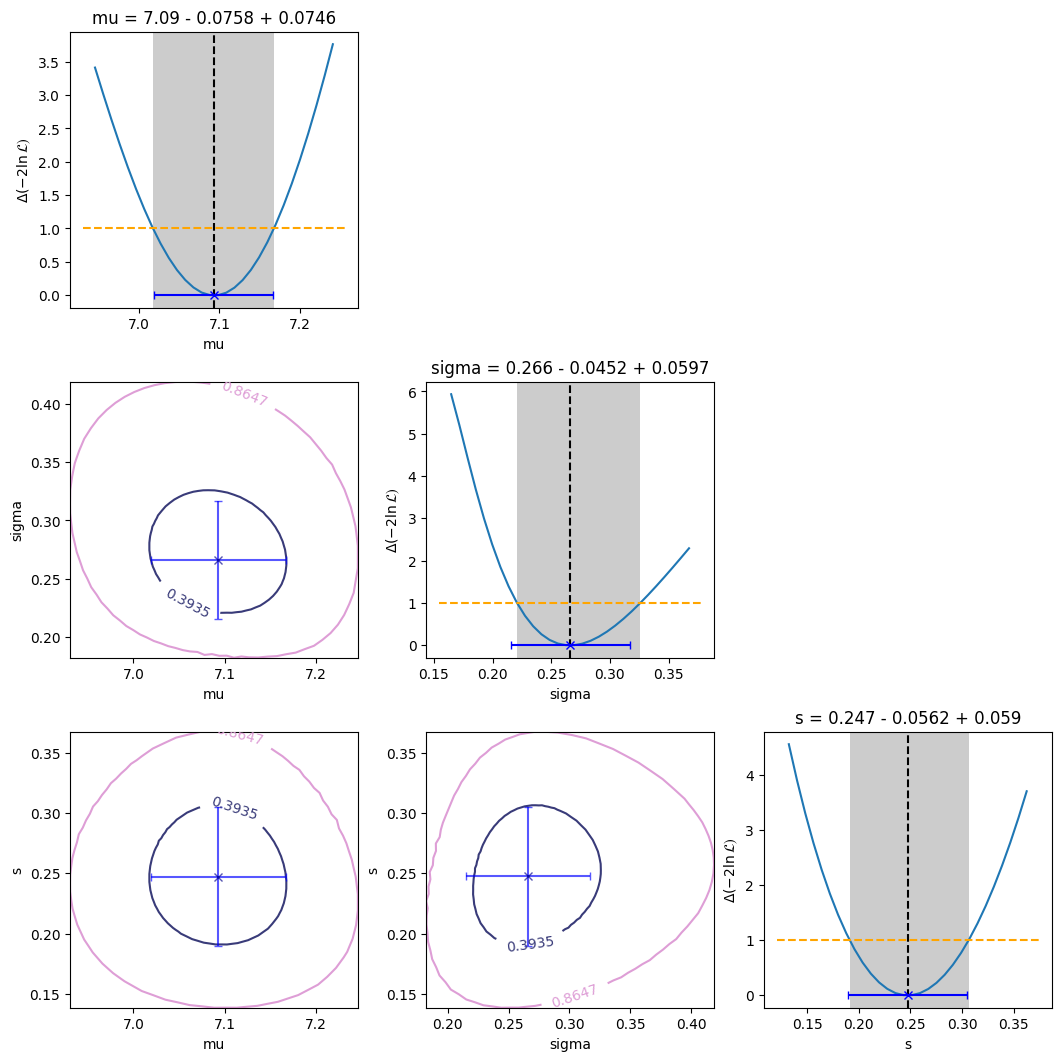


*==* histogram fit Result:
 parameter names:        ('mu', 'sigma', 's')
 goodness-of-fit: 35.8
 parameter values:       [7.09319061 0.26610602 0.24736214]
 neg. parameter errors:  [-0.07576898 -0.04516454 -0.05622502]
 pos. parameter errors:  [0.07458932 0.05972126 0.05896517]
 correlations : 
 [[ 1.         -0.12026333 -0.04426505]
 [-0.12026333  1.          0.12765636]
 [-0.04426505  0.12765636  1.        ]]


In [20]:
from PhyPraKit.phyFit import hFit


#  the model function to fit
def SplusB_model(x, mu=6.987, sigma=0.5, s=0.2):
    """(normalized) pdf of a Gaussian signal on top of flat background"""
    normal = np.exp(-0.5 * ((x - mu) / sigma) ** 2) / np.sqrt(2.0 * np.pi * sigma**2)
    linear = 1.0 / (xmx - xmn)
    return s * normal + (1 - s) * linear


# the histogram data
nbins = 40
xmn = 1
xmx = 10
bedges = np.linspace(xmn, xmx, nbins + 1)
bcontents = np.array([1, 1, 1, 2, 2, 2, 4, 1, 0, 3, 1, 1, 0, 2, 3, 3, 1, 1, 0, 2,
                      3, 2, 3, 1, 1, 8, 6, 7, 9, 1, 0, 1, 2, 1, 3, 2, 1, 3, 2, 4])
#
# ---  perform fit
#
hFit_results = hFit(
    SplusB_model,
    bcontents,
    bedges,  # bin entries and bin edges
    limits=[("s", 0.0, None), ("sigma", 0.0, None)],  # parameter limits
    plot=True,  # plot data and model
    plot_band=True,  # plot model confidence-band
    plot_cor=True,  # plot profiles likelihood and contours
    axis_labels=["x", "y   \  f(x, *par)"],
    data_legend="peudo-data",
    model_legend="signal + background model",
)

# Print results
# pvals, perrs, cor, chi2, pnams = hFit_results
print("\n*==* histogram fit Result:")
print(" parameter names:       ", hFit_results["parameter names"])
print(" goodness-of-fit: {:.3g}".format(hFit_results["goodness-of-fit"]))
print(" parameter values:      ", hFit_results["parameter values"])
print(" neg. parameter errors: ", hFit_results["confidence intervals"][:, 0])
print(" pos. parameter errors: ", hFit_results["confidence intervals"][:, 1])
print(" correlations : \n", hFit_results["correlation matrix"])

Die grafische Ausgabe zeigt die angepasste Verteilungsdichte sowie deren Unsicherheit, die durch 
Propagation der Parameterunsicherheiten auf die Modellvorhersage bestimmt wird. 
Die rechteckigen Flächen repräsentieren die Zahl der in den Daten beobachteten Einträge und 
entsprechen der klassischen Histogramm-Darstellung. Die um die Modellfunktion eingezeichneten
Fehlerbalken zeigen den 68.3%-Konfidenzbereich für die unter Zugrundelegung der Poission-Verteilung
erwartete Zahl an Einträgen in jedem Bin. Die Größe "g.o.f" (= "goodness of fit") ist die 
Differenz des beobachteten Werts von $n2l{\cal L}$ und dem bestmöglichen Wert dieser Größe, 
den man erhält, wenn alle Daten auf der Modellvorhersage liegen, dem sog. "Saturated Model"; 
g.o.f. konvergiert für große Datensätze gegen die aus der Anpassung mit der Methode der kleinsten
Fehlerquadrate bekannte Größe $\chi^2$.

Ein **Vergleich mit der Gauß-Näherung** ist durch Angabe einer weiteren Option
`use_GaussApprox=True` beim Aufruf von *hFit* leicht möglich. Hier das gleiche
Beispiel, bei dem im Vergleich zu vorhin nur diese Option geändert wurde. 

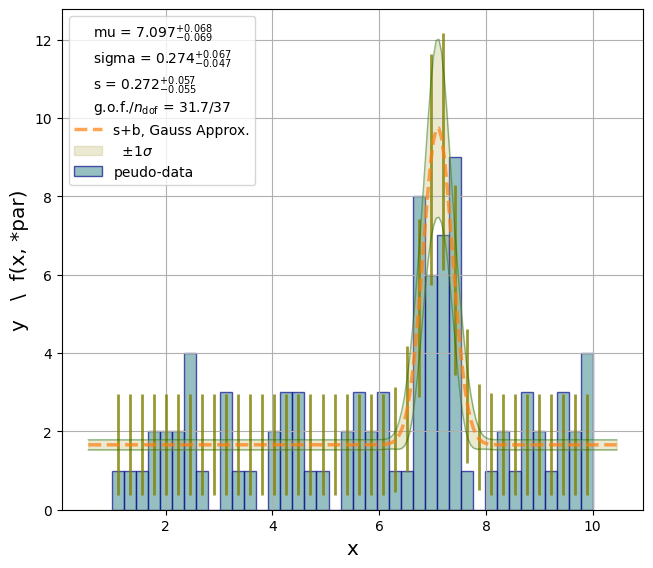


*==* histogram fit with Gaussian cost:
 parameter names:        ('mu', 'sigma', 's')
 goodness-of-fit: 31.7
 parameter values:       [7.09681353 0.27407023 0.27181286]
 neg. parameter errors:  [-0.06854522 -0.04662249 -0.0553459 ]
 pos. parameter errors:  [0.06773086 0.06732895 0.05723184]
 correlations : 
 [[ 1.         -0.01498253 -0.03844071]
 [-0.01498253  1.          0.00572968]
 [-0.03844071  0.00572968  1.        ]]


In [21]:
#
# ---  perform 2nd Fit with Gaussian cost function
#
results_ga = hFit(
    SplusB_model,
    bcontents,
    bedges,  # bin entries and bin edges
    limits=[("s", 0.0, None), ("sigma", 0.0, None)],  # parameter limits
    use_GaussApprox=True,  # use Gaussian approxmiation of Poisson distr.
    plot=True,  # plot data and model
    plot_band=True,  # plot model confidence-band
    plot_cor=False,  # plot profile likelihoods and contours
    axis_labels=["x", "y   \  f(x, *par)"],
    data_legend="peudo-data",
    model_legend="s+b, Gauss Approx.",
)

# Print results
# pvals, perrs, cor, chi2, pnams = results_ga
print("\n*==* histogram fit with Gaussian cost:")
print(" parameter names:       ", results_ga["parameter names"])
print(" goodness-of-fit: {:.3g}".format(results_ga["goodness-of-fit"]))
print(" parameter values:      ", results_ga["parameter values"])
print(" neg. parameter errors: ", results_ga["confidence intervals"][:, 0])
print(" pos. parameter errors: ", results_ga["confidence intervals"][:, 1])
print(" correlations : \n", results_ga["correlation matrix"])


Die Ergebnisse sind recht ähnlich, allerdings zeigt sich ein signifikanter Unterschied 
beim angepassten Signalanteil, der in der Gauß-Näherung um fast die Hälfte seiner Unsicherheit größer als in der korrekten, auf der Poissonverteilung beruhenden 
Anpassung geschätzt wird. 
Der Grund dafür sind die asymmetrischen Unsicherheitsintervalle der Poissonverteilung, die 
im Bereich des Signals kleinere Werte der angepassten Verteilungsdichte bevorzugen. In 
der Praxis würde man in diesem Fall auf die Anwendung der Gauß-Näherung verzichten. 


### 3.2 Signifikanz eines Signals und Ausschlussgrenze 

Mit Hilfe der Profil-Likelihood lassen sich noch viel weitergehende Aussagen über 
einen Parameter treffen.
Ein oft anzutreffendes Beispiel ist die Suche nach einem Signal-Peak über einem
Untergrund, wie wir sie oben schon behandelt haben. Die Größe des Signals, also der
Wert des Parameters $s$, war dabei sehr deutlich von Null verschieden. Bei 
kleineren Signalen stellt sich die Frage, ob sie überhaupt "signifikant" sind 
oder nicht auch das Ergebnis einer Fluktuation des Untergrunds sein könnten.
Ein häufig  verwendetes Mass für die Signifikanz $S$ einer Signalstärke "s" ist 
der auf seine Unsicherheit $\sigma_s$ normierte Abstand des Signalparameters von 
Null - das entpricht der Aussage:
"Wir haben ein Signal mit einer Signifikanz von z Sigma beobachtet". Je größer
dieser Abstand, desto unwahrscheinlicher ist eine statistische Fluktuation des
Untergrunds als Ursache für den lokalen, als Signal fehlinterpretierten 
Überschusses an Histogrammeinträgen. 

Wenn der Verlauf der Likelihood am Minimum von der Parabelform abweicht, 
ist das kein gutes Maß mehr. 
Man spezifiziert dann den Abstand von Null als den Logarithmus des Verhältnisses der 
Profil-Likelihood für Signalgröße $s=0$ und am Optimum, $s=\hat{s}$. 
Die Wurzel aus diesem Verhältnis stellt den sogenannten $z$-Wert dar, den wir schon
ober eingeführt hatten und der die äquivalente Anzahl an Standardabweichungen einer
Gaußverteilung ausdrückt, um die der Erwartungswert von Null abweicht. 
Es gilt

\begin{equation}
  z^2 =  -2 \ln \left( \frac{{\cal L}_{prof}(0)} {{\cal L}_{prof}(\hat{s})} \right)
  = \left( -2\ln{\cal L}_p(s=0) \right) - \left( -2\ln{\cal L}_p(s=\hat{s}) \right)
  = -2\Delta\ln{\cal L}_p(s) \,.
\end{equation}

$S=z$ ist die Signifikanz in "Anzahl $\sigma$s", wie wir es oben etwas
unpräzise ausgedrückt hatten. 
Der Term $-2\Delta\ln{\cal L}$ entpricht der auf den Wert am Minimum bezogenen 
Kostenfunktion, die zur Besimmung der Signifikanz an den Stellen $s=0$ und 
$s=\hat{s}$ bestimmt werden muss.

Anders als häufig in der Physik gibt man die Signifikanz in der professionellen 
Statistik als $p$-Wert an, den man durch Berechnung des entsprechenden Wertes der 
kumulativen Verteilungsdichte der Standardnormalverteilung erhält:
$p_s$ = 1-*scipy.stats.norm.cdf*($z$). 
Üblicherweise wählt man den $p$-Wert bzgl. der Nullhypothese, $p_0 = 1 - p_s$, 
der die Übereinstimmung der Beobachtung mit der Null-Hypothese quantifiziert. 
Je kleiner der Wert von $p_0$, desto schlechter passt die Null-Hypothese und 
desto gesicherter ist damit die Existenz der beobachteten, als Signal 
bezeichneten Abweichung.

Wenn das Signal nicht hinreichende signifikant ist, sollte man eine Obergrenze
für die Signalgröße angeben; üblich ist hier eine Ausschlussgrenze mit einem 
Konfidenznievau von cl=95%. Übersetzt in eine Änderung der Profil-Likelihood
relativ zu ihrem Wert am Optimum wird diese Grenze wieder durch die Verwendung
des entsprechenden Quantils der Standardnormalverteilung bestimmt, das über die 
Funktion $z_{cl}$ = scipy.statsnorm.ppf(cl)* (ppf = percent point function, 
die Inverse der kumulativen Verteilungsfunkton cdf) berechnet werden kann.
Die zugehörige Änderung des Logarithmus der Profil-Likelihood ist $z_{cl}^2$
und entspricht für cl=95% dem Wert 2.71. 


Um solche Untersuchungen durchführen zu können, braucht man Zugriff auf die 
Profil-Likelihood. Mit Hilfe der Funktion *mFit()* gelingt das, wenn man nicht 
die Ergebnisse der Anpassung, sondern die entsprechende Instanz der Klasse *mnFit* 
als Ausgabe anfordert, indem man den Parameter `return_fitObject = True` angibt. 
Damit hat man Zugriff auf alle Daten und Methoden der Klasse *mnFit*.

Um die Signalsuche etwas realistischer zu gestalten, wurde in den Daten im Beispiel 
von vorhin das Signal um einen Faktor Zwei verkleinert. 
Damit die Anpassung auch für kleine angenommene Signalstärken noch konvergiert, 
sollten noch Position und Breite des gesuchten Signals fixiert werden und 
vorher geeignete Werte gesetzt werden. 

Der leicht modifizierte Code für unser bereits bekanntes Beispiel sieht nun so aus: 

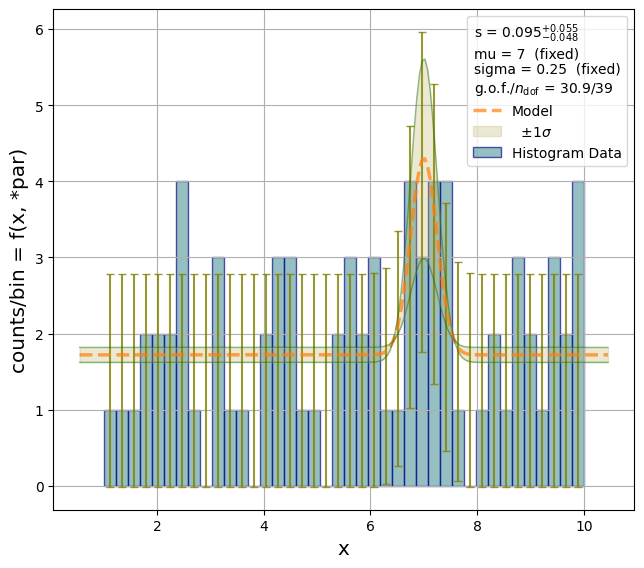

In [22]:
# the modified histogram data
nbins = 40
xmn = 1
xmx = 10
bedges = np.linspace(xmn, xmx, nbins + 1)
bcontents2 = np.array(
    [
        1,
        1,
        1,
        2,
        2,
        2,
        4,
        1,
        0,
        3,
        1,
        1,
        0,
        2,
        3,
        3,
        1,
        1,
        0,
        2,
        3,
        2,
        3,
        1,
        1,
        4,
        3,
        4,
        4,
        1,
        0,
        1,
        2,
        1,
        3,
        2,
        1,
        3,
        2,
        4,
    ]
)
# ---  perform fit
hFitObj = hFit(
    SplusB_model,
    bcontents2,
    bedges,  # bin entries and bin edges
    p0=[7.0, 0.25, 0.2],  # set (initial) parameter values
    fixPars=["mu", "sigma"],  # fix signal position and shape
    limits=[("s", 0.0, None)],  # parameter limits
    return_fitObject=True,
)

Das *Python-Dictionary* mit den Ergebnissen erhält man mit der Methode *getResult()*
der Klasse *mnFit*:  
```
resultDict = hFit.getResult()
```

In [23]:
# get and print results
pvals, perrs, cor, gof, pnams = hFitObj.getResult().values()
print("\n*==* histogram fit with small signal:")
print(" parameter names:       ", pnams)
print(" parameter values:      ", pvals)
print(" neg. parameter errors: ", perrs[:, 0])
print(" pos. parameter errors: ", perrs[:, 1])
print(" correlations : \n", cor)


*==* histogram fit with small signal:
 parameter names:        ['s' 'mu' 'sigma']
 parameter values:       [0.09462446 7.         0.25      ]
 neg. parameter errors:  [-0.04848818]
 pos. parameter errors:  [0.05514042]
 correlations : 
 [[1.]]


Die Profil-Likelihood für einen Parameter mit dem Namen *name* wird mit dem Aufruf 
der Methode *getProfile()* der Klasse *mnFit* berechnet und zurückgegeben:
```
pvals, nlLp, status = hFitObj.getProfile(name, range, npoints)
```

Ähnlich wie im grafische Beispiel in Kap. 2 verwedenden wir ein Hilfsfunktion
*analyse_signal()*, um die Profil-Likelihood auzuwerten. Dieses Mal interessiert
uns aber nicht der Zentralbereich der Kurve in der Nähe des Minimums, sondern
die Ränder. Hier der Code zur Erzeugung und Auswertung der Profil-Likelihood,
der auch eine anschauliche grafische Darstellung der in der Beschreibung oben
skizzierten Zusammenhänge erzeugt:  



 == Analysis of profile likelihood
  Significance, z-value: 2.14
  p-value of Null-hypothesis: 0.016
  95% limit: s < 0.188




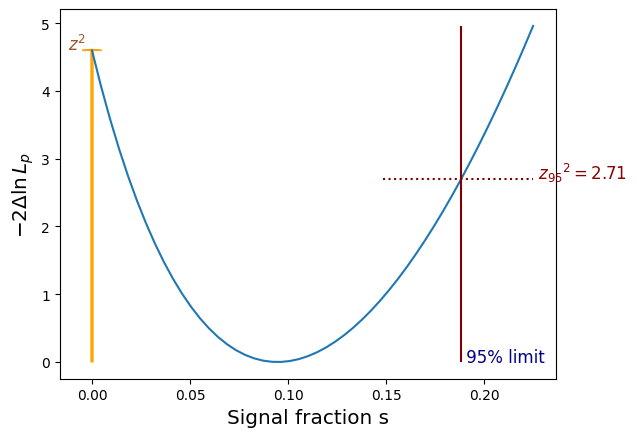

In [24]:
# get profile likelihood (in range [0., mx]
mx = 0.225
vals, n2lLp, status = hFitObj.getProfile("s", range=(0.0, mx), npoints=50)


# analyze profile likelihood
def analyze_signal(vals, n2lLp):
    from scipy.stats import norm
    from scipy.interpolate import CubicSpline
    from scipy.optimize import newton

    n2lLp_spline = CubicSpline(vals, n2lLp)

    # Determine significance of parameter
    z = np.sqrt(n2lLp_spline(0.0))
    p_0 = 1.0 - norm.cdf(z)

    # Determin upper limit on parameter
    z_95 = norm.ppf(0.95)  #  z-value for 95%

    def f(x):
        return n2lLp_spline(x) - z_95**2

    s95 = newton(f, x0=pvals[0], x1=mx)

    # - plot profile likelihood
    plt.plot(vals, n2lLp)
    plt.xlabel("Signal fraction s", size="x-large")
    plt.ylabel("$-2 \Delta \ln L_p$", size="x-large")

    # - plot significance
    z2 = z * z
    plt.arrow(0, 0, 0, z2, head_width=0.01, color="orange")
    plt.text(-mx / 15, z2, " $z^2$", size="large", color="sienna")

    # - plot limit
    plt.hlines(z_95**2, 0.66 * mx, mx, color="maroon", linestyle="dotted")
    plt.vlines(s95, 0, n2lLp_spline(mx), color="maroon")
    plt.text(
        mx,
        z_95**2,
        " ${{z_{{95}}}}^2=$" + str("{:.3g}".format(z_95**2)),
        size="large",
        color="darkred",
    )
    plt.text(s95, 0.0, " 95% limit", size="large", color="darkblue")

    return z, p_0, s95


# perform analysis of signal properties using function
z, p_0, s95 = analyze_signal(vals, n2lLp)
print("\n")
print(" == Analysis of profile likelihood")
print("  Significance, z-value: {:.3g}".format(z))
print("  p-value of Null-hypothesis: {:.3g}".format(p_0))
print("  95% limit: " + pnams[0] + " < {:.3g}".format(s95))
print("\n")

Das Signal hat also eine relativ schwache Signifikanz von nur
$z=2.14$ (oder "$2.14 \sigma$"); dies entspricht einem $p$-Wert 
für die Null-Hypothese von $1.6\%$. Üblicherweise verlangt man
$z$-Werte von mindestens $3$, häufig sogar $z \ge 5$, um sich gegen
falsche Entdeckungen abzusichern, die auftreten, wenn man an sehr
viele Stellen sucht, also mit verschiedenen Methoden in vielen
Verteilungen an verschiedenen, vorher nicht bekannten Stellen
im Parameterraum (der sog. "look-elsewhere effect"). 

Im vorliegenden Fall würde man also nicht von der Entdeckung eines
Signals sprechen, sondern eine Obergrenze auf einen möglichen Signalanteil
von $s < 0.188$ bei einem Konfidenzniveau von 95% setzen.

***
## 4. Maximum-Likelihood und Methode der kleinsten Fehlerquadrate
***

Die Methode der kleinsten Fehlerquadrate zur Anpassung von Modellen ist
ein Spezialfall des Maximum-Likelihood Verfahrens.
Um das zu sehen, leiten wir allgemein ein auf der log-Likelihood Methode 
basierendes Anpassungsverfahren für Modellfunktionen an Messdaten her.

Wir bezeichnen die zufällige Abweichung eines Messwertes vom wahren
Wert mit $z$, die durch eine Verteilungsdichte $f_z$
beschrieben wird. Im Falle von Messunsicherheiten ist $f_z$ häufig
die Normalverteilung mit Erwartungswert Null und Standardabweichung $\sigma$,
${\cal N}(z; \sigma)$. Im mehrdimensionalen Fall für $n_d$ nicht
notwendigerweise unabhängige Datenpunkte ist die multivariate
Gaußverteilung ${\cal N}(\vec z; V)$ mit der Kovarianzmatrix $V$ relevant,

\begin{equation}\label{equ-mStandardGauss}
  {\cal{N}}\left(\vec{z}, V) \right) = 
\frac{1} {\sqrt{(2\pi)^{n_d} \det(V)} }
\cdot
\exp \left( -\frac{1}{2} \vec{z}^T V^{-1} \vec{z}
\right) \,.
\end{equation}

Die Zufallsgröße $z$ mit Erwartungswert Null entspricht den Fluktuationen 
um den wahren Wert. Wenn es für den wahren Wert eine exakte theoretische 
Erwartung in Form eines parameterbehafteten Modells $f_i(\vec p)$ mit einem 
Satz an Parametern $\vec p$ gibt, lässt sich ein Messwert $y_i$ schreiben als
\begin{equation}\label{equ-zplusw}
y_i =  f_i(\vec p) + z_i \,.
\end{equation}

Üblicherweise führt man zum Test von parameterbehafteten, durch
Funktionen beschriebenen Modellen mehrere Messungen an verschiedenen
Stützstellen $x_i=(\vec x)_i$ durch, man betrachtet also eine Modellfunktion
$f(\vec x; \vec p)$.
Die Verteilungsdichte, die alle Messungen beschreibt, sieht dann so aus:

\begin{equation}\label{equ-mGauss}
  {\cal{N}}\left(\vec{y}, V, f(\vec{x}, \vec{p}) \right) = 
  \frac{1} {\sqrt{(2\pi)^{n_d} \det(V)} } \cdot
  \exp\left( -\frac{1}{2} (\vec{y}-\vec{f})^T V^{-1} (\vec{y}-\vec{f}) \right) \,.
\end{equation}

Nach dem Maximum-Likelihood-Prinzip ist der beste Parametersatz durch
den Punkt ${\hat{\vec{ p}}}$ im Parameterraum gegeben, für den die Likelihood
maximal wird. Wie schon oben verwendet man das Zweifache des negativen natürlichen
Logarithmus der Likelihood, $n2l{\cal L}_{Gauß}$, der dann minimiert wird.

\begin{equation}\label{equ-nlLGauss}
-2\, \ln{\cal{L_{\rm Gauß}}}\left( \vec y, V, \vec{f}(\vec x, \vec {p}) \right)
\,=\, \left(\vec y - \vec f(\vec x; \vec p ) \right)^T V^{-1}
  \left(\vec y - \vec f(\vec x; \vec p ) \right)
  + \ln(\det(V)) + n_d\,\ln(2\pi) \,.
\end{equation}

Für die Bestimmung des Minimums von $n2l{\cal L}_{Gauß}$ sind bzgl. der
Parameter konstante Terme nicht relevant, man kann sie daher weglassen.
Wenn die Normierung der Gaußverteilung, also der Term $\det(V)$, nicht
von den Parametern abhängt, vereinfacht sich der obige Ausdruck
zum altbekannten Ausdruck für die quadratische Residuensumme mit 
Kovarianzmatrix, $S$:

\begin{equation}\label{equ-chi2}
S\left(\vec y, V, \vec{f}(\vec x, \vec {p})\right) \,=\,
  \left(\vec y - \vec f(\vec x; \vec p ) \right)^T V^{-1}
  \left(\vec y - \vec f(\vec x; \vec p ) \right) \,.
\end{equation}

Unter speziellen Bedingungen sind also die Minimierung von 
$n2l{\cal{L}}$ und der quadratischen Summe der Residuen $S$ 
äquivalent. 
Dieser einfache Fall ist aber nicht mehr gegeben, wenn relative, 
auf den Modellwert bezogene Unsicherheiten auftreten, oder wenn 
Unsicherheiten in Abszissen-Richtung behandelt werden sollen, die 
mit Hilfe einer Taylor-Entwicklung erster Ordnung von der Abszisse 
auf die Ordinate übertragen werden und damit von der Ableitung des 
Modells nach $x$ und so auch von den Parameterwerten abhängen.
Die praktische Regel lautet daher, möglichst immer die Likelihood
zu verwenden, und nur in gut begründeten, berechtigten Fällen
auf die Methode der kleinsten Fehlerquadrate zurück zu greifen.
Allerdings ist man bei der Wahl der verfügbaren numerischen
Werkzeuge stark eingeschränkt, wenn man diese Empfehlung
umsetzen möchte.

Sollen Problemstellungen mit nicht Gauß-förmigen Verteilungen
behandelt werden, ist die Verwendung von log-Likelihoodverfahren
unumgänglich. Das Aufstellen entsprechender Likelihood-Funktionen
zur Behandlung spezieller Problemstellungen gehört in der
wissenschaftlichen Praxis heute zum Standard. Dank sehr leistungsfähiger
Algorithmen zur numerischen Minimierung in hoch-dimensionalen
Parameterräumen und auch Dank moderner Computertechnik stellt
die Verwendung korrekter Likelihood-Verfahren kein
unüberwindliches Problem mehr dar.

### Praktische Hinweise

In der Praxis sind die oben beschriebenen Verfahren nur in Kombination mit 
numerischen Verfahren zur Minimierung von skalaren Funktionen in mehr- oder
sogar hoch-dimensionalen Räumen und Programmcode zur Verwaltung der Daten
und ihrer Unsicherheiten durchführbar. Obwohl in seltenen Fällen auch analytische
Lösungen existieren, nutzt man in der Praxis fast ausschließlich Programmpakete
zur Durchführung von Anpassungen; analytische (Teil-)Lösungen müssen nur
eingesetzt werden, wenn es um zeitkritische Problemstellungen geht. 

#### Konstruktion der Kovarianzmatrix

Die Kovarianzmatrix der Daten bildet die Unsicherheiten Gauß-verteilter 
Eingabedaten vollständig ab. Wird sie bei der Anpassung berücksichtigt, 
werden alle zwischen den Daten unabhängigen und korrelierten Unsicherheiten
beim Anpassungsprozess in das Endergebnis propagiert - eine klassische 
Fehlerrechnung von Hand ist dann nicht mehr notwendig. 

Fassen wir zunächst kurz die wesentlichen Eigenschaften der
Kovarianzmatrix ${\bf V}$ zusammen:

- ${\bf V} = \left(\mathrm{V}_{ij}\right)$ ist eine symmetrische Matrix;
- sie hat die Dimension $n_d$, die der Anzahl der Messwerte entspricht;
- für unabhängige Messwerte ist die Matrix diagonal;
- die Nebendiagonalelemente $V_{ij},\,{\small i\ne j}$ lassen sich verstehen als
  das Produkt der gemeinsamen Unsicherheiten $\sigma^g_i$ und $\sigma^g_j$ der 
   Messungen $i$ und $j$;
- die Kovarianzmatrix-Elemente für voneinander unabhängige Unsicherheiten
  werden addiert.

Gerade der letzte Punkt ist von entscheidender Bedeutung, denn er erlaubt es,
die vollständige Kovarianzmatrix sukzessive aus einzelnen Beiträgen zur
Unsicherheit aufzubauen, mit der Konstruktionsvorschrift:

- Unsicherheiten der Messwerte werden nach verschiedenen, unabhängigen
  Quellen aufgeschlüsselt.
- Unabhängige Unsicherheiten jeder einzelnen Messung werden quadratisch in
  den Diagonalelementen aufaddiert.
- Allen Messwerten oder Gruppen von Messungen gemeinsame absolute oder
  relative Unsicherheiten werden quadratisch in den betreffenden
  Diagonal- und Nebendiagonalelementen $V_{ii}$, $V_{jj}$ und $V_{ij}$ aufaddiert.

Unsicherheiten in Abszissenrichtung, gegeben durch eine Kovarianzmatrix
${\bf V}^x$, können berücksichtigt werden, in dem man sie mit Hilfe der
Modellvorhersage $f(\vec x, \vec p)$ per Taylor-Entwicklung in erster Ordnung
in y-Richtung transformiert und dann zur Kovarianz-Matrix der Datenpunkte in
y-Richtung, ${\bf V}^y$, addiert:

\begin{equation}\label{equ-xyCovariance}
  V_{ij} = (V^y)_{ij} 
        +  \frac{\partial f}{\partial x_i} \frac{\partial f}{\partial x_j} (V^x)_{ij} 
\end{equation}

Insgesamt ergeben sich so acht Arten von Unsicherheiten, nämlich 
unabhängige und / oder korrelierte
absolute und / oder relative Unsicherheiten in
$x$- und / oder $y$-Richtung.

Zum Bau der Kovarianzmatrix setzt man idealerweise Programmcode ein. Die
wenigsten gängigen Anpassungsprogramme bringen dafür direkt Optionen mit,
sondern es muss die vollständige Kovarianzmatrix als Parameter übergeben
werden.
Das Paket *kafe2* enthält die Methode   
`add_error(err_val, axis=?, correlation=?, relative=?, reference=?)`   
mit deren Hilfe einzelne Komponenten der Unsicherheit hinzugefügt werden
können. Die Interfaces zu verschiedenen Anpassungsprogrammen
im Paket *PhyPraKit* sehen ebenfalls die Angabe einzelner Komponenten
der Unsicherheit als Parameter vor, wenn die entsprechenden Anpassungspakete
dies unterstützen.
Alle acht Arten von Unsicherheiten können direkt nur mit *kafe2* oder 
mit *PhyPraKit.phyFit* behandelt werden. 

#### Berücksichtigung externer und eingeschränkter Parameter

Häufig hängen Modellfunktionen von externen, mit Unsicherheiten behafteten 
Parametern ab, die z.$\,$B. in einer Hilfsmessung bestimmt wurden oder aus der
Literatur stammen. Dies können die Ergebnisse von Kalibrationsmessungen sein,
oder auch Natur- oder Apparatekonstanten. Statt die Effekte der Parameterunsicherheiten 
mit Hilfe einer händischen Fehlerrechnung auf das Endergebnis zu propagieren, 
können  sie auch als eingeschränkte Parameter ("constrained parameter") direkt 
in der Anpassung berücksichtigt werden. 
Dazu werden solche Parameter gleichzeitig als freie Parameter in der 
Anpassung und als Messgrößen eingeführt - d.$\,$h. ein entsprechender Term 
zur log-Likelihood hinzugefügt. 

Notwendig ist bisweilen auch eine Methode, mit deren Hilfe Parameter auf 
feste Werte fixiert werden können.
Der Einfluss externer Parameter kann damit auch untersucht werden, indem
man sie nacheinander auf ihren Erwartungswert und die jeweiligen oberen bzw. 
untere Grenzen ihres Konfidenzbereichs fixiert und die Veränderungen des 
Anpassungsergebnisses beobachtet.

Das temporäre Fixieren und wieder frei geben von Parametern kann auch hilfreich 
sein, wenn eine komplexe Anpassung nicht zum globalen Minimum konvergiert. Man 
kann dann einen oder einige Parameter in der Nähe des erwarteten Wertes fixieren 
und eine Minimierung bezüglich der übrigen Parameter vornehmen. Wenn man dann an 
diesem temporären Minimum die fixierten Parameter wieder frei gibt, sollte 
die Anpassung zum globalen Minimum konvergieren. 

Ein Problem während des Anpassungsprozesses stellen oft auch Parameter dar,
die temporär Werte in mathematisch nicht definierten Wertebereichen oder in 
unphysikalischen Bereichen annehmen (negative Werte unter Wurzeln, negative
Massen etc). Das Setzen von Limits zum Vermeidung solcher Parameterbereiche
ist eine wichtige Option für jedes Anpassungspaket. 

Bei nichtlinearen Problemstellungen gibt es häufig neben dem globalen Minimum
weitere Nebenminima - oder sogar mehrere oder viele gleichwertige Lösungen. 
In solchen Fällen werden Startwerte für die Parameter in der Nähe
einer "vernünftigen" Lösung benötigt. Auch diese Möglichkeit muss ein 
Anpassungspaket bieten. Da im Laufe des besseren Verständnisse aus manchem 
einfachen Problem später ein nichtlineares Problem werden kann, ist es eine 
gute Angewohnheit, grundsätzlich immer Startwerte zu setzen.


Ein Beispiel mit allen acht oben genannten Arten von Unsicherheiten ist in der Code-Zelle
unten gezeigt. Alle in der Funkion *xyFit()* verfügbaren Optionen sind ebenfalls angegeben,
auch wenn für die meisten "vernünftige" Voreinstellungen gelten und man sich die explizite
Angabe häufig ersparen kann. 

### Beispiel zur Anpassung an x/y-Daten

Ein Beispiel, bei dem alle acht Fehlertypen vorkommen, ist im folgenden Code-Beispiel zur 
Anwendung der Funktion *xyFit*

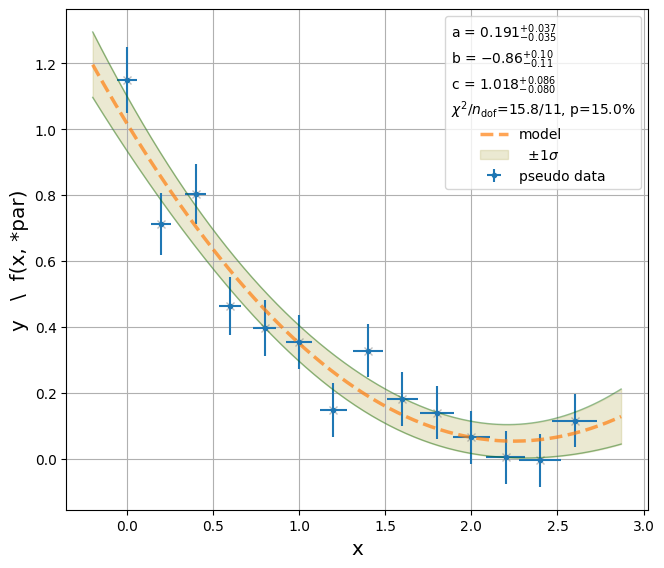

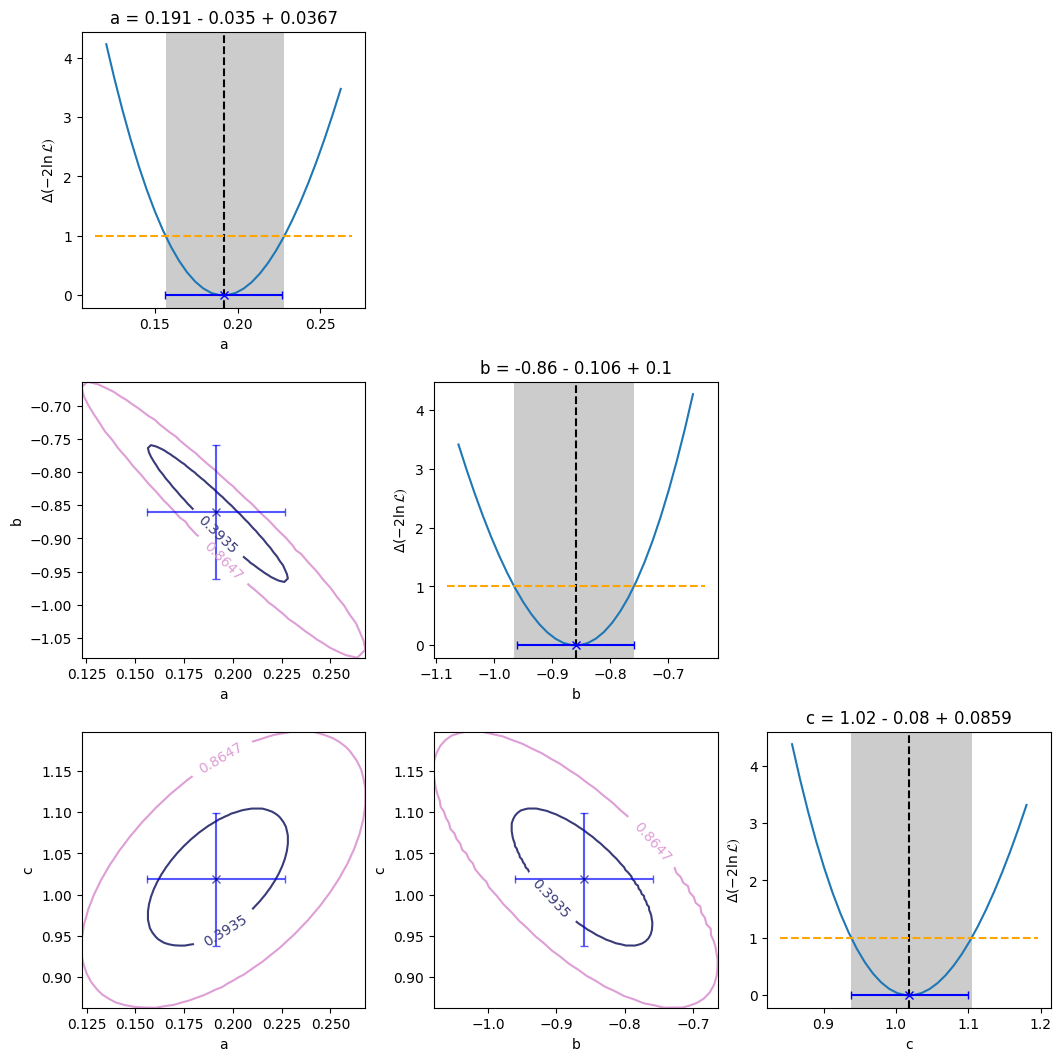


*==* xyFit Result:
parameter values
 [ 0.19147397 -0.85971999  1.01844637]
confidence intervals
 [[-0.03499509  0.03672393]
 [-0.10583673  0.10015959]
 [-0.08004777  0.08592092]]
correlation matrix
 [[ 1.         -0.95408115  0.5409451 ]
 [-0.95408115  1.         -0.70200198]
 [ 0.5409451  -0.70200198  1.        ]]
goodness-of-fit
 15.774326904497318
parameter names
 ('a', 'b', 'c')


In [25]:
 from PhyPraKit.phyFit import xyFit

#
# *** Example of an application of phyFit.mFit()
#
# define the model function to fit
def exp_model(x, A=1., x0=1.):
  return A*np.exp(-x/x0)

# another model function
def poly2_model(x, a=0.1, b=1., c=1.):
  return a*x**2 + b*x + c

# set model to use in fit
#fitmodel=exp_model  # also try poly2_model !
fitmodel=poly2_model  # also try exp_model!
  
# the data ...
data_x = [0.0, 0.2, 0.4, 0.6, 0.8, 1., 1.2,
          1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
data_y = [1.149, 0.712, 0.803, 0.464, 0.398, 0.354, 0.148,
          0.328, 0.181, 0.140, 0.065, 0.005,-0.005, 0.116]
# ... and components of the uncertaity 
sabsy = 0.07 # independent y
srely = 0.05 # 5% of model value
cabsy = 0.04 # correlated
crely = 0.03 # 3% of model value correlated
sabsx = 0.05 # independent x
srelx = 0.04 # 4% of x
cabsx = 0.03 # correlated x
crelx = 0.02 # 2% of x correlated

# perform fit to data with function xyFit using class mnFit
results = xyFit(fitmodel,      # the model function
           data_x, data_y,     # x and y data
           sx=sabsx,           # the error components defined above
           sy=sabsy,
           srelx=srelx,
           srely=srely,
           xabscor=cabsx,
           xrelcor=crelx,
           yabscor=cabsy,
           yrelcor=crely,
#           p0=(1., 0.5),     # start values of parameters (taken from model if not given)
#           constraints=['A', 1., 0.03],    # constraint(s)
#           constraints=[0, 1., 0.03]       # alternative specificaiton of constraints
#           limits=('A', 0., None),  # parameter limits
#           fixPars = ['A'],         # parameter(s) to be fixed to start value 
           use_negLogL=True,         # use full n2lL (default)
           plot=True,                # plot data and model 
           plot_band=True,           # plot model uncerctainty
           plot_cor=True,            # plot profiels and contours
           quiet=True,               # silent output it True
           axis_labels=['x', 'y   \  f(x, *par)'], 
           data_legend = 'pseudo data',    
           model_legend = 'model')

# Print results 
print('\n*==* xyFit Result:')
for key in results:
  print("{}\n".format(key), results[key])



***
## 5. Beurteilung der Qualität von Anpassungsverfahren
***

Die oben schon genannten Qualitätsanforderungen an ein Schätzverfahren können 
je nach gewähltem Verfahren, aber auch abhängig von der Größe einer Stichprobe 
bzw. der gewählten Parametrisieung der Modellfunktion unterschiedlich gut erfüllt
sein. 

Hier nich einmal die Zusammenstellung der relevanten Eigenschaften,die eine
Parameterschätzung erfüllen sollte:

  - konsistent: $\displaystyle \lim_{n \to \infty} \hat{p}_i = p_i$
  
  - möglichst erwartungstreu schon bei kleinen Stichproben: $E[\hat{p}_i] = p_i$   
  
  - möglichst unverzerrt: Verzerrung $b$ (=bias) $b_i=E[\hat{p}_i] - p_i$ = 0,   
    für große Stichproben muss wegen der geforderten Konsistenz gelten
    $\displaystyle \lim_{n \to \infty} b = 0$
  
  - optimal: $V[\hat{p}_i]$ minimal   
  
  - robust: unbeeinflusst von "Ausreißern" oder leichten Fehlmodellierungen der Daten
  
  - korrekte Überdeckungswahrscheinlichkeit (engl. "coverage"): 
    $W(p_i \in [\hat{p}_i - \Delta p_i, \hat{p}_i +\Delta p_i])= 68.3\%$  

Die hier diskutierte Maximum-Likelihood Methode (MLE) ist optimal, allerdings eher nicht
robust, weil falsche Annahmen über das Modell einen empfindlichen Einfluss auf die
Parameterwerte haben können. MLE-Schätzungen sind in der Regel auch nicht unverzerrt; 
wenn nicht unbedingt der Punkt der besten Anpassung ("Punktschätzung"), sondern, wie 
häufig in der Physik ein möglichst korrektes Konfidenzintervall ("Intervallschätzung") 
für den Schätzwert von Belang ist, spielt das allerdings eine untergeordnete Rolle. 
Wie wir schon oben gesehen hatten, existiert für die Bestimmung der Unsicherheiten nur 
eine Ungleichung (Cramér-Rao-Fréchet Grenze). Wie gut bestimme Verfahren typischerweise
nach den oben genannten Kriterien funktionieren, ist oft empirisch bekannt. Mann kann
zeigen, dass z.$\,$B. die Methode der kleinsten Fehlerquadrate für lineare Problemstellungen
und Gauß-förmige Messunsicherheiten optimal und unverzerrt ist. Die hier skizzierten
Likelihood-Verfahren erfüllen die oben genannten Bedingungen schon für recht kleine 
Stichproben ebenfalls gut. 

### Überprüfung mittels Monte-Carlo - Methode ("toy-MC")

Zur Überprüfung der Eigenschaften eines Schätzverfahrens und des Einflusses der Stichprobengröße
werden in der Praxis häufig Ensemble-Tests durchgeführt - d.h. man erzeugt zufällig eine große 
Anzahl gleichwertiger Stichproben und führt jeweils das Anpassungsverfahren durch.
Aus einer statistischen Analyse der Ergebnisse lassen sich dann die Eigenschaften des
Schätzverfahrens bestimmen.

Zur Simulation der Stichproben verwendet man die Monte-Carlo Methode; weil die Simulation
für diesen Zweck sehr einfach sein kann, nennt man solche Studien auch "toy-Monte Carlo".

Beispielcode zur Erzeugung künstlicher "Pseudo-Daten" ist in den folgenden Codezellen gezeigt.
Die durchgeführte Anpassung entspricht dem schon oben diskutierten Beispiel zur Anpassung
einer Modellfunktion an x/y-Daten mit verschiedenen Typen von Unsicherheiten. 


Hier der Code-Teil zur Definition aller Parameter zur Datenerzeugung und zur Anpassung:

In [26]:
from PhyPraKit import generateXYdata
from PhyPraKit.phyFit import xyFit, get_functionSignature
import matplotlib.pyplot as plt
from scipy import stats


# define some models to test
def exp_model(x, A=1.0, x0=1.0):
    return A * np.exp(-x / x0)


# another model function
def poly2_model(x, a=0.75, b=1.0, c=1.0):
    return a * x**2 + b * x + c


# set model to use ...
model = poly2_model
# model = exp_model

# ... and number of pseudo-experiments to perform
Nexp = 200

# parameters of pseudo-data
nd = 120  # number of data points
xmin = 0.0  # x-range
xmax = 2.5
data_x = np.linspace(xmin, xmax, nd)  # x of data points

# extract model paramerters from model function
mpardict = get_functionSignature(model)[1]  # keyword arguments of model
true_vals = np.asarray(list(mpardict.values()))
npar = len(mpardict)
parnams = list(mpardict.keys())

# set uncertainties for x/y pseudo-data
# - independent absolute uncertainties
sabsx = 0.05  # 0.05
sabsy = 0.07  # 0.07
# - indepentent relative uncertainties
srelx = 0.04  # 4%
srely = 0.03  # 5% of model value
# correlated uncertainties in x  and y direction
cabsx = 0.03  # 0.03
crelx = 0.02  # 2%
cabsy = 0.04  # 0.04
crely = 0.03  # 3% of model value

# calulate total uncertainties
sigx = np.sqrt(sabsx * sabsx + (srelx * data_x) ** 2)
sigy = np.sqrt(sabsy * sabsy + (srely * model(data_x, **mpardict)) ** 2)

# set keyword arguments for fit function xyFit
kw_uncertainties = {  # - components of uncertainty
    "sx": sabsx,  # indep x
    "sy": sabsy,  # indel y
    "srelx": srelx,  # indep. rel. x
    "srely": srely,  # indep. rel. y
    "xabscor": cabsx,  # correlated x
    "xrelcor": crelx,  # correlated rel. x
    "yabscor": cabsy,  # correlated y
    "yrelcor": crely,  # correlated rel. y
}

kw_options = {  # options for Fit
    "ref_to_model": True,  # reference of rel. uncert. to model
    "use_negLogL": True,  # standard chi^2 if false
}

Die Schleife zur Erzeugung der Daten, Modellanpassung und die Analyse der Ergebnisse 
ist in der folgenden Codezelle gezeigt. Für die  Analyse der individuellen Ergebnisse 
der Anpassung sind die folgenden Zeilen zuständig. Sie speichern die individuellen 
Ergebnisse, berechnen die $\chi^2$-Wahrscheinlichkeit, die Verzerrung und eine Bool'sche 
Variable für die Auswertung der Überdeckung zur späteren statistischen Auswertung:

```
 #  calculate chi2 probability
    chi2prb = 1.- stats.chi2.cdf(chi2, nd-len(pvals))
    c2prb.append(chi2prb)
    
    # analyze bias and coverage
    for i in range(npar):
      biases[i].append( pvals[i] - true_vals[i] )  # bias
      # get parameter confidence interval (CI)
      pmn = pvals[i] + perrs[i,0]
      pmx = pvals[i] + perrs[i,1]
      # coverage: count how often true value is in CI
      if (true_vals[i] >= pmn and true_vals[i]<=pmx): N_coverage[i] +=1
```


In [27]:
# this is the loop part of the MC simulation


def MC_loop():
    global nfail, biases, c2prb, N_coverage
    # initialize arrays for statistical analysis in loop
    nfail = 0  # counter for failed fits
    biases = [[] for i in range(npar)]  # bias
    c2prb = []  # chi^2 probatility
    N_coverage = npar * [0]  # counters for coverage

    #
    # start toy-MC loop --------------------------------------------
    #
    print("generating data - patience please!")
    for iexp in range(Nexp):
        # generate a sample of peudo-data
        np.random.seed(
            314159 + (iexp * 2718281) % 100000
        )  # initialize random generator
        xt, yt, data_y = generateXYdata(
            data_x,
            model,
            sigx,
            sigy,
            xabscor=cabsx,
            xrelcor=crelx,
            yabscor=cabsy,
            yrelcor=crely,
            mpar=true_vals,
        )
        # perform fit to pseudo data
        try:
            plot = True if iexp < 1 else 0
            result = xyFit(
                model,
                data_x,
                data_y,  # model & data
                **kw_uncertainties,  # all uncertainties
                **kw_options,  # fit options
                plot=plot,  # plot data and model
                showplots=False,  # call plt.show() in user code if False
            )

            # save fit results in local variables
            pvals, perrs, cor, chi2, pnams = result.values()

            if plot:
                plt.suptitle("Result of fit {:d}".format(iexp))

            if iexp < 1:
                # Print results to illustrate how to use output
                np.set_printoptions(precision=6)
                print("\n*==*  Fit {:d} Result:".format(iexp))
                print(f" chi2: {chi2:.4g}")
                print(f" parameter names:  ", pnams)
                print(f" parameter values:  ", pvals)
                np.set_printoptions(precision=3)
                print(f" parameter errors: ", perrs)
                np.set_printoptions(precision=3)
                print(f" correlations : \n", cor)
                np.set_printoptions(precision=8)  # default output precision
                print()
            else:
                # show simple progress bar
                if (100 * iexp) % Nexp == 0:
                    print("*", end="")

            #  calculate chi2 probability
            chi2prb = 1.0 - stats.chi2.cdf(chi2, nd - len(pvals))
            c2prb.append(chi2prb)

            # analyze bias and coverage
            for i in range(npar):
                biases[i].append(pvals[i] - true_vals[i])  # bias
                # get parameter confidence interval (CI)
                pmn = pvals[i] + perrs[i, 0]
                pmx = pvals[i] + perrs[i, 1]
                # coverage: count how often true value is in CI
                if true_vals[i] >= pmn and true_vals[i] <= pmx:
                    N_coverage[i] += 1

        except Exception as e:
            nfail += 1
            print("!!! fit failed ", nfail)
            print(e)

#### Auswertung der Ergebnisse

Die Code zur Analyse der in der Schleife aufgezeichneten Daten gibt zunächst die für
jeden der Parameter beobachtete Verzerrung aus, zusammen mit deren durch die endliche
Statistik bedingten Parameterunsicherheiten. Statistisch signifikant sind nur Verzerrungen, 
die deutlich größer als die Unsicherheit auf den Mittelwert der Abweichungen sind. Zur Bewertung
der Relevanz muss man sie in Bezug auf die Unsicherheit der Parameterwerte, also der Breite
der Verteilung der Abweichungen, setzen. Erst wenn sie eine bedeutsame Größe davon erreichen, 
typischerweise größer als 5% - 10%,  sollten die Verzerrungen angegeben werden. 

Als zweite Größe wird die Coverage ausgegeben, die dem Anteil der Fälle entspricht, in
denen der wahre Parameterwert innerhalb des Unsicherheitsintervalls liegt.

generating data - patience please!

*==*  Fit 0 Result:
 chi2: 101.6
 parameter names:   ('a', 'b', 'c')
 parameter values:   [0.704721 1.195344 0.968146]
 parameter errors:  [[-0.051  0.055]
 [-0.104  0.107]
 [-0.067  0.067]]
 correlations : 
 [[ 1.    -0.523  0.359]
 [-0.523  1.    -0.057]
 [ 0.359 -0.057  1.   ]]

***************************************************************************************************

*==* sucessfully analyzed 200 data sets


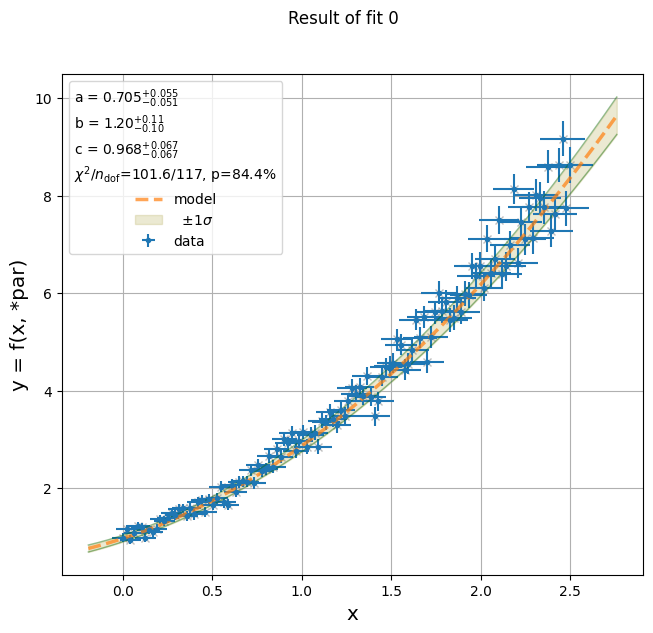

In [28]:
# run MC loop
MC_loop()
print("\n\n*==* sucessfully analyzed {:d} data sets".format(Nexp - nfail))

In [29]:
def print_result():
    global nfail, biases, c2prb, N_coverage

    # - convert output to numpy arrays
    for i in range(npar):
        biases[i] = np.array(biases[i])
    c2prb = np.array(c2prb)

    ## plt.show() # blocks at this stage until figure deleted
    # results as printout
    N_succ = Nexp - nfail
    print("\n\n*==* ", N_succ, " successful fits done:")
    print(" * parameter names:")
    for i in range(npar):
        print("   {:d}: {:s}".format(i, pnams[i]))

    print(" * biases:")
    for i in range(npar):
        #  bias = deviation of parameters from their true values
        b = biases[i].mean()
        s = biases[i].std()
        e = s / np.sqrt(Nexp)
        print("   {:d}: {:.3g} +\- {:.2g}, std {:.3g}".format(i, b, e, s))

    print(" * coverage:")
    for i in range(npar):
        #  coverage: fraction of true val in confidence interval
        p_coverage = N_coverage[i] / (N_succ) * 100 // 0.682689492
        print("   {:d}: {:.3g}%".format(i, p_coverage))


print_result()



*==*  200  successful fits done:
 * parameter names:
   0: s
   1: mu
   2: sigma
 * biases:
   0: -0.00545 +\- 0.004, std 0.0568
   1: -5.6e-05 +\- 0.0078, std 0.11
   2: 0.00762 +\- 0.0042, std 0.0599
 * coverage:
   0: 90%
   1: 95%
   2: 104%


In diesem Beispiel gibt es keine signifikanten Verzerrungen, und die Überdeckung liegt
in der Nähe des für ein $\pm 1\sigma$-Intervall erwarteten Werts, d.h. 100% von 68.3%.

#### Grafische Darstellung der Ergebnisse

Eine einfache grafische Darstellung der Ergebnisse zeigt das Code-Fragment unten. 
Verwendung findet eine allgemeine Funktion zur Darstellung von Verteilungen und Korrelationen 
eines Datensatzes mit mehreren Variablen aus dem Paket *PhyPraKit*. 

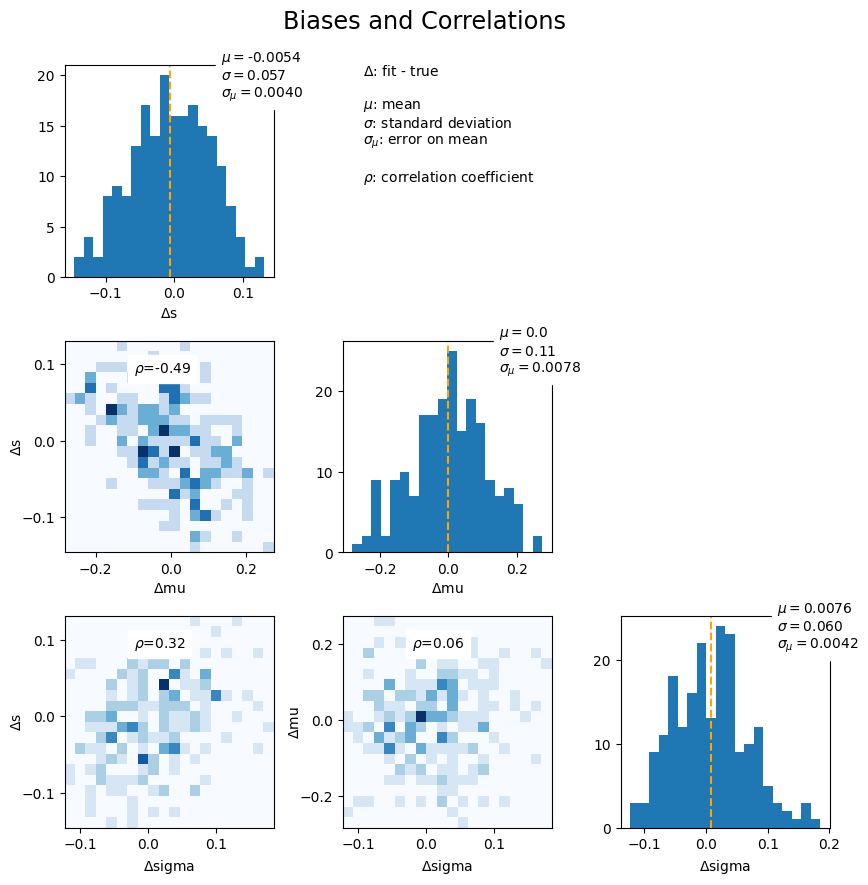

In [30]:
from PhyPraKit import plotCorrelations


def plot_correlations():
    global nfail, biases, c2prb, N_coverage
    # plot results as array of sub-figures
    names = [r"$\Delta$" + pnams[i] for i in range(len(pnams))]
    fig, axarr = plotCorrelations(biases, names)
    fig.suptitle("Biases and Correlations", size="xx-large")
    ax = axarr[0][1]
    ax.text(
        0.1,
        0.45,
        "$\\Delta$: fit - true \n \n"
        + "$\\mu$: mean \n"
        + "$\\sigma$: standard deviation \n"
        + "$\\sigma_\\mu$: error on mean \n \n"
        + "$\\rho$: correlation coefficient",
        transform=ax.transAxes,
    )
    plt.show()


plot_correlations()

Die beobachteten Verteilungen bestätigen die Schätzungen der Unsicherheiten und der Korrelationen durch die in *xyFit()* verwendeten Methoden. Wenn sich deutliche Unterschiede ergeben hätten, würde man die aus der Ensemble-Studie abgeleiteten Unsicherheiten und Korrelationen als Ergebnis angeben.

#### Verlässlichkeit des Hypothesentests

Als letztes Beispiel ist unten die Überprüfung der Qualität der als Hypothesentest eingesetzten
und aus dem in der Anpassung erhaltenen Wert von $\chi^2$ am Optimum und der Zahl der Freiheitsgrade
berechneten $\chi^2$-Wahrscheinlichkeit gezeigt. Diese sollte flach sein, wenn die Größe zur Bestimmung
der Goodness-of-Fit tatsächlich einer $\chi^2$-Verteilung folgt. 

compatibility of chi2 probability with flat distribution: 10.854834%


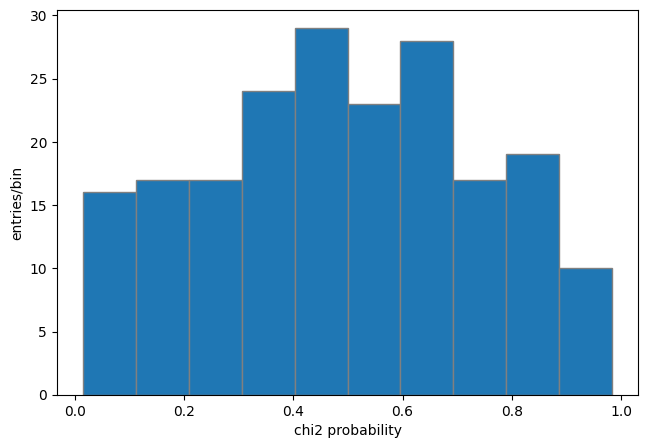

In [31]:
def analyse_chi2():
    global nfail, biases, c2prb, N_coverage
    # analysis of chi2 probability
    figc2prb = plt.figure(figsize=(7.5, 5.0))
    ax = figc2prb.add_subplot(1, 1, 1)
    nbins = int(min(50, Nexp / 20))
    binc, bine, _ = ax.hist(c2prb, bins=nbins, ec="grey")
    plt.xlabel("chi2 probability")
    plt.ylabel("entries/bin")
    # - check compatibility with flat distribution
    mean = (Nexp - nfail) / nbins
    chi2flat = np.sum((binc - mean) ** 2 / mean)
    prb = 1.0 - stats.chi2.cdf(chi2flat, nbins)
    print(
        "compatibility of chi2 probability with flat distribution: {:f}%".format(
            prb * 100
        )
    )

    plt.show()


analyse_chi2()

In diesem Fall ist die beobachtete Verteilung tatsächlich im Rahmen eines ebenfalls mit der
$\chi^2$-Methode durchgeführten Tests auf Übereinstimmung mit einer Rechteckverteilung flach. Allerdings zeigen sich bei Erhöhung der Zahl der untersuchten Stichproben statistisch
signifikante Abweichungen, die aber noch hinreichend klein sind, so dass man den Wert von
$\chi^2$ als Qualitätskriterium für die Anpassung verwenden kann. Mit Hilfe der nun
aus dem Ensemble-Test bekannten Verteilung könnte man auch die kritische Grenze für das 
Verwerfen der Modellhypothese entsprechend anpassen. 

Übrigens: der Hauptgrund für die Abweichung der $\chi^2$-Wahrscheinlichkeit von der 
Rechteckverteilung sind in diesem Beispiel die relativen, auf den Modellwert bezogenen
Unsicherheiten der Messdaten. Schaltet man diese in der Simulation und im Modell aus,
ergibt sich eine deutlich bessere Übereinstimmung mit der Rechteckverteilung. 

#### Überprüfung der Robustheit

Die Überprüfung der Robustheit einer Anpassung ist eines der schwierigsten Probleme. 
Auch hier helfen Ensemble-Tests, bei denen dann aber Stichproben der Daten erzeugt werden,
die anders aussehen als im Modell angenommen. So können Effekte von falsch abgeschätzten
Unsicherheiten, leicht variierten Modellfunktionen oder von seltenen Ausreißern in 
Verteilungen studiert werden. 

#### Studie 1: Behandlung relativer Unsicherheiten

Mit dem oben definierten Set-up sind nun leicht weitere Studien der Auswirkungen bestimmter 
Optionen der Anpassung leicht durchzuführen. Dazu müssen lediglich die entsprechenden Optionen
verändert und die Sequenz der oben durchgeführten Schritte wiederholt werden. 
Gezeigt ist das im Beispiel in der nächsten Zelle für den Fall, dass relative Unsicherheiten auf die 
Daten statt auf den Modellwert bezogen werden. 

generating data - patience please!

*==*  Fit 0 Result:
 chi2: 105.5
 parameter names:   ('a', 'b', 'c')
 parameter values:   [0.631066 1.076625 0.873969]
 parameter errors:  [[-0.052  0.055]
 [-0.103  0.106]
 [-0.068  0.068]]
 correlations : 
 [[ 1.    -0.391  0.433]
 [-0.391  1.     0.018]
 [ 0.433  0.018  1.   ]]

***************************************************************************************************

*==* sucessfully analyzed 200 data sets


*==*  200  successful fits done:
 * parameter names:
   0: s
   1: mu
   2: sigma
 * biases:
   0: -0.0958 +\- 0.0035, std 0.0495
   1: -0.126 +\- 0.0068, std 0.0965
   2: -0.11 +\- 0.0036, std 0.0508
 * coverage:
   0: 30%
   1: 56%
   2: 26%


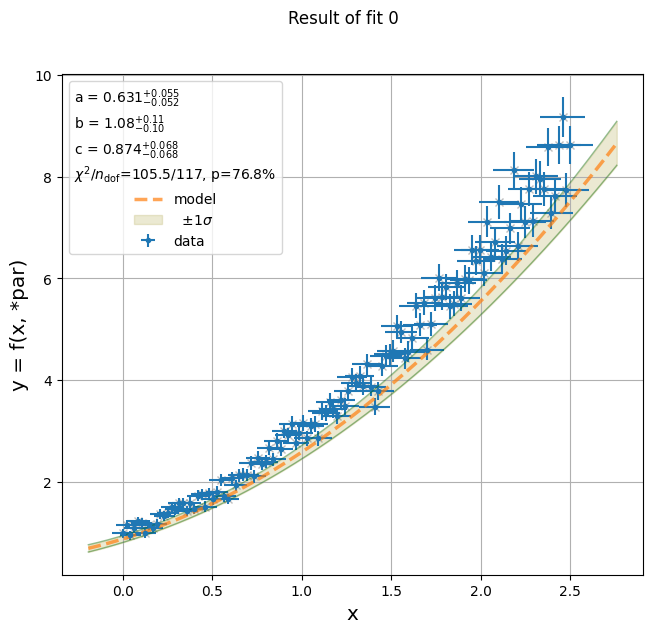

In [32]:
# modify fit optoins
kw_options = {  # options for Fit
    "ref_to_model": False,  # !!! rel. uncert. w.r.t to data
    "use_negLogL": True,  # standard chi^2 if false
}
# execute MC loop and analysis ...
MC_loop()
# ... and print results
print("\n\n*==* sucessfully analyzed {:d} data sets".format(Nexp - nfail))
print_result()

Wie die Ausgabe zeigt, sind die Parameter nun signifikant verzerrt, und im Vergleich zur 
Standardabweichung sind diese Verzerrungen auch relevant. die Überdeckung ist ebenfalls 
sehr viel schlechter geworden, d.h. die Angaben der Unsicherheiten sind in diesem  Fall
nicht zuverlässig. Die grafische Darstellung der Ergebnisse des ersten Pseudodatensatzes
zeigt, was passiert: Datenpunkten, die zu kleineren Werten fluktuieren, werden kleinere 
relative Unsicherheiten zugewiesen, und dementsprechend größere Unsicherheiten für Datenpunkte,
die zu größeren Werten fluktuieren. Im Ergebnis wird die angepasste Modellfunktion dadurch hin zu
kleineren $y$-Werten gezogen.  Nicht in allen Fällen ist der Effekt so deutlich in der Ergebnisgrafik
sichtbar wie in diesem Fall! Den größten Beitrag zur offensichtlichen Abweichung des angepassten
Modells an die Daten liefert übrigens die relative, korrelierte Unsicherheit von 3% auf die $y$-Werte.

#### Studie 2: Vergleich mit der Methode der kleinsten Quadrate

Verwendet man anstelle der Likelihood-Methode die klassische $\chi^2$-Methode, so ergeben 
sich ebenfalls starke Verzerrungen und schlechte Werte für die Abdeckung des Konfidenzintervalls
der Parameter. 

generating data - patience please!

*==*  Fit 0 Result:
 chi2: 82.18
 parameter names:   ('a', 'b', 'c')
 parameter values:   [0.895477 1.437303 1.126419]
 parameter errors:  [[-0.081  0.09 ]
 [-0.137  0.144]
 [-0.081  0.085]]
 correlations : 
 [[ 1.    -0.365  0.386]
 [-0.365  1.     0.087]
 [ 0.386  0.087  1.   ]]

***************************************************************************************************

*==* sucessfully analyzed 200 data sets


*==*  200  successful fits done:
 * parameter names:
   0: s
   1: mu
   2: sigma
 * biases:
   0: 0.206 +\- 0.0053, std 0.0756
   1: 0.229 +\- 0.0085, std 0.121
   2: 0.166 +\- 0.0048, std 0.068
 * coverage:
   0: 5%
   1: 30%
   2: 13%


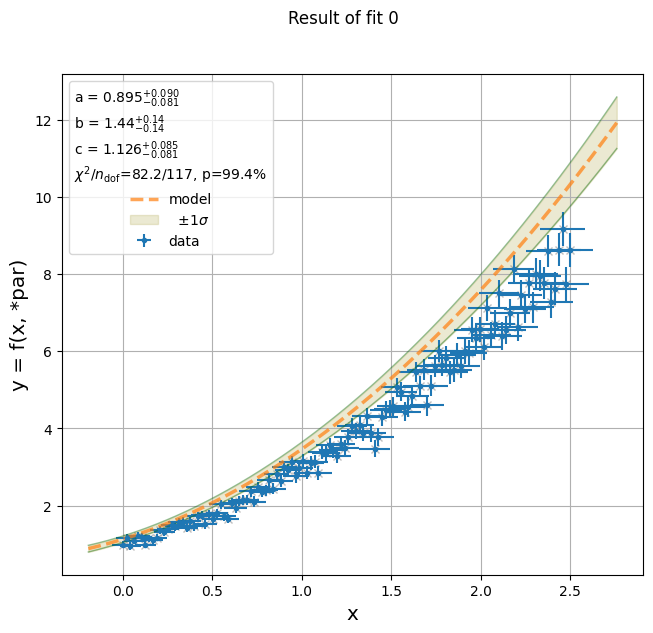

In [33]:
# modify fit optoins
kw_options = {  # options for Fit
    "ref_to_model": True,  # rel. uncert. w.r.t model
    "use_negLogL": False,  # !!! use standard chi^2
}
# execute MC loop and analysis ...
MC_loop()
print("\n\n*==* sucessfully analyzed {:d} data sets".format(Nexp - nfail))
# ... and print results
print_result()

In diesem Fall wird die angepasste Modellfunktion hin zu größeren $y$-Werten gezogen. Der Grund
ist die Vernachlässigung der parameterabhängigen Unsicherheiten in der Kostenfunktion. 
Wenn die Modellfunktion größere Werte vorhersagt, werden auch die relativen Unsicherheiten 
entsprechend größer und damit der $\chi^2$-Wert entsprechend kleiner. Der Term $\ln(\det(V))$ 
in der vollen log-Likelihood wirkt diesem Effekt entgegen. Wieder ist in vielen Fällen das Problem
nicht so klar sichtbar wie in diesem Beispeil mit recht großen Anteilen relativer Unsicherheiten.
Der Test "mit dem Auge", d.h. scheinbar gute Übereinstimmung von Datenpunkten und Modell, 
täuscht oft.

**Resumé:**  
Als Ergebnis dieser Studie ist festzuhalten, dass relative Unsicherheiten auf die Modellwerte 
bezogen werden müssen und dazu eine Likelielihood als Kostenfunktion notwendig ist.
In den Paketen *kafe2* und *PhyPraKit.phyFit* ist das korrekte Verhalten voreingestellt. 
Bei Verwendung anderer Anpassungsprogramme ist Vorsicht geboten, wenn relative 
Unsicherheiten im Spiel sind. 

***
# Abschließende Anmerkungen

Mit den in diesem Tutorial beschriebenen Verfahren zur Anpassung von Modellen an Messdaten
sind Sie für Anwendungen in den Fortgeschrittenenpraktika oder in Ihren Abschlussarbeiten
bestens gerüstet. Die beschriebenen Methoden entsprechen den in der Wissenschaft üblichen,
und Sie werden in wissenschaftlichen Veröffentlichungen einigen davon wieder begegnen. 

Die hier gezeigten Beispiele basieren mit Absicht auf dem schlanken Anpassungswerkzeug 
*phyFit*, um die Transparenz der Vorgehensweise sicher zu stellen und Ihnen durch 
Modifikation der Beispiele eigene Studien und Anpassungen an spezielle Problemstellungen
zu ermöglichen. Da *phyFit* nur eine schlanke Interface-Ebene darstellt und im Übrigen auf dem 
im wissenschaftlichen Umfeld seit langem etablierten und anerkannten Paket MINUIT zur Optimierung
in hochdimensionalen Parameterräumen und zur Schätzung der  Parameterunsicherheiten basiert, sind 
Ihre damit erzielten Ergebnisse fachlich sehr gut abgesichert und in eigenen Arbeiten "zitierfähig".


***
***